# Statistiky k bakalářské práci Arbitrážní příležitosti kryptoměn
**Autor: Čeněk Žid**

In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join, isdir
from typing import Dict, Tuple, Sequence
from copy import deepcopy
import threading
import os
from datetime import datetime
from collections import Counter
import scipy.stats
from math import isnan
import warnings

In [2]:
#  Exchange rates from cryptocurrencies to USDT (USD) (Binance.com, 13.4.2020) 
rate = {
    "BTC": 6837.51,
    "LTC": 41,
    "ETH": 156.7,
    "XRP": 0.185965,
    "USDT": 1,
    "BCH": 222.98,
    "BNB": 15.53,
    "EOS": 2.44,
    "XMR": 53.37,
    "TRX": 0.012597
}
title_font_size = 20  # title font size for the charts
label_font_size = 13  # ticks labels font size
path = "./output_data/"    

In [3]:
def fetch_directories(path: str) -> [str]:
    '''
    Fetches all directories in the given path 
    '''
    directories = []
    try:
        directories = [join(path, f) for f in listdir(path) if isdir(join(path, f))] 
    except:
        print("Trouble opening a directory")
        return directories
    return directories

def fetch_files(path: str) -> [str]:    
    '''
    Fetches all files in the given path 
    '''
    files = []
    try:
        files = [f for f in listdir(path) if isfile(join(path, f))] 
    except:
        print("Trouble opening a directory")
        return files
    return files

            
def flatten(l: [[any]]) -> [any]:
    '''
    Takes a 2-D array and flattens it into a 1-D array
    '''
    return [item for sublist in l for item in sublist]

In [4]:
class FileHandler:
    def __init__(self, file: str, path: str):
        self.filename = file
        self.total_gain = 0
        self.average_gain = 0
        self.max_gain = 0
        self.best_gains = None
        self.date = file[-15:-5:]
        with open(join(path, file)) as f:
            tmp = json.loads(f.read())
            self.content = tmp["arbitrage_stats"]
            self.arbitrages_count = tmp["arbitrages_count"]
            self.without_fees_count = tmp["without_fees_count"]
            self.all_count = tmp["all_count"]
        self.scores = [x["score"] for x in self.content]
    
    @property
    def filename(self) -> str:
        return self.__filename
    
    @filename.setter
    def filename(self, filename: str):
        self.__filename = filename
        
    @property
    def content(self) -> str:
        return self.__content
    
    @content.setter
    def content(self, content: str):
        self.__content = content
        
    @property
    def total_gain(self) -> float:
        return self.__total_gain
    
    @total_gain.setter
    def total_gain(self, total_gain: float):
        self.__total_gain = total_gain
        
    @property
    def max_gain(self) -> float:
        return self.__max_gain
    
    @max_gain.setter
    def max_gain(self, max_gain: float):
        self.__max_gain = max_gain
        
    @property
    def average_gain(self) -> float:
        return self.__average_gain
    
    @average_gain.setter
    def average_gain(self, average_gain: float):
        self.__average_gain = average_gain
        
    @property
    def scores(self) -> [float]:
        return self.__scores
    
    @scores.setter
    def scores(self, scores: [float]):
        self.__scores = scores
        
    @property
    def arbitrages_count(self) -> int:
        return self.__arbitrages_count
    
    @arbitrages_count.setter
    def arbitrages_count(self, arbitrages_count: int):
        self.__arbitrages_count = arbitrages_count     
        
    @property
    def without_fees_count(self) -> int:
        return self.__without_fees_count
    
    @without_fees_count.setter
    def without_fees_count(self, without_fees_count: int):
        self.__without_fees_count = without_fees_count  
        
    @property
    def all_count(self) -> int:
        return self.__all_count
    
    @all_count.setter
    def all_count(self, all_count: int):
        self.__all_count = all_count  
        
    @property
    def date(self) -> str:
        return self.__date
    
    @date.setter
    def date(self, date: str):
        self.__date = date  
        
    def get_best_indexes_count(self) -> Dict[int, int]:
        '''
        Goes through the content returns a dictionary of the best indexes (indexes for the best arbitrage)
        '''
        indexes = np.array([x['supply_gain_index'] for x in self.content]).ravel()
        tmp = np.array([x['demand_gain_index'] for x in self.content]).ravel()
        indexes = np.array((indexes, tmp)).ravel()
        unique, counts = np.unique(indexes, return_counts = True)
        return dict(zip(unique, counts))
    
    def get_number_of_arbitrages(self) -> int:
        '''
        Returns a number of arbitrages
        '''
        return len(self.scores)
    
    def get_average_score(self) -> float:
        '''
        Returns an averages score of all arbitrages (returns 1 if there are no arbitrages)
        '''
        if len(self.scores):
            return sum(self.scores)/len(self.scores)
        return 1
    
    def get_best_score(self) -> float:
        '''
        Retruns the best score from all the arbitrages in a day
        '''
        if len(self.scores):
            return max(self.scores)
        return 1
    
    def get_best_gains(self) -> float:
        '''
        Sets properties (average_gain, total_gain) and returns the non-zero gains
        '''
        best_gains = np.array([x["supply_gain"] for x in self.content])
        best_gains = np.array((best_gains, [x["demand_gain"] for x in self.content])).ravel()
        best_gains = best_gains[self.best_gains != 0.0]
        self.total_gain = np.sum(best_gains)
        self.average_gain = np.nanmean(best_gains)
        if len(best_gains[0]):
            self.max_gain = np.max(best_gains)
        else:
            self.max_gain = 0
        return best_gains

    def get_first_currency(self) -> str:
        '''
        Returns the currency name of the main currency
        '''
        if (self.content):
            return self.content[0]['pairs'][0]['currency'][0:3]
        return ""
    
    def time_distribution_by_hours(self) -> Counter:
        '''
        Transforms the greatest timestamp to hours in a day and returns a Counter() of calculation of the hours.
         '''
        hour_array = [datetime.fromtimestamp(max(x['pairs'][0]['timestamp'], x['pairs'][1]['timestamp'], x['pairs'][2]['timestamp'])).hour for x in self.content]
        counter = Counter()
        for x in hour_array:
            counter[x] += 1
        return counter 
    
    def time_distribution_by_weekdays(self) -> Counter:
        '''
        Transforms the greatest timestamp to a weekday and returns a Counter() of calculation of the weekdays.
         '''
        weekday_array = [datetime.fromtimestamp(max(x['pairs'][0]['timestamp'], x['pairs'][1]['timestamp'], x['pairs'][2]['timestamp'])).weekday() for x in self.content]
        counter = Counter()
        for x in weekday_array:
            counter[x] += 1
        return counter 
    
    def get_deltatimes(self) -> [float]:
        '''
        Returns a deltatime as a duration of the arbitrage.
        '''
        return [x['time_delta'] for x in self.content]
    
    def check_data(self) -> bool:
        return_value = True
        tmsp = self.timestamp_check()
        if tmsp:
            print("Checking", self.filename)
#             print('Number of suspiciosly long timestamp deltas', tmsp)
            print("Deltatimes", tmsp)

        for opportunity in self.content:
            main_indicator = ''
            secondary_indicator = ''
            if opportunity['supply_gain'] > 0:
                main_indicator = 'supply'
                secondary_indicator = 'demand'
            else:
                main_indicator = 'demand'
                secondary_indicator = 'supply'
            score = opportunity['score']
            gain = opportunity[main_indicator + '_gain']
            indexes = opportunity[main_indicator + '_gain_index']
            calculated_score = 1
            thinnest_part = 0
            if main_indicator == 'supply':
                calculated_score = 1 / opportunity['pairs'][0][main_indicator][indexes[0]][0] * opportunity['pairs'][1][secondary_indicator][indexes[1]][0] * opportunity['pairs'][2][secondary_indicator][indexes[2]][0]
                thinnest_part = min(
                    opportunity['pairs'][0]['supply'][indexes[0]][1],
                    opportunity['pairs'][1]['demand'][indexes[1]][1],
                    opportunity['pairs'][2]['demand'][indexes[2]][1] 
                        * opportunity['pairs'][2]['demand'][indexes[2]][0]
                        / opportunity['pairs'][0]['supply'][indexes[0]][0]
                   )
            else:
                calculated_score = opportunity['pairs'][0][main_indicator][indexes[0]][0] / opportunity['pairs'][1][secondary_indicator][indexes[1]][0] / opportunity['pairs'][2][secondary_indicator][indexes[2]][0]
                thinnest_part = min(
                    opportunity['pairs'][0]['demand'][indexes[0]][1],
                    opportunity['pairs'][1]['supply'][indexes[1]][1],
                    opportunity['pairs'][2]['supply'][indexes[2]][1] 
                        / opportunity['pairs'][1]['supply'][indexes[1]][0]
                   )
            calculated_score *= 0.999**3
            calculated_gain = (calculated_score - 1) * thinnest_part
            tolerance = 0.00000001
            if not (calculated_gain * (1-tolerance) < gain < calculated_gain * (1+tolerance)):
                print(gain, calculated_gain)
                return_value = False
            if not (calculated_score - tolerance < score < calculated_score + tolerance):
                print(score, calculated_score)
                return_value = False
        return return_value
    
    def timestamp_check(self) -> int:
        deltas = []
        ret_val = 0
        for opportunity in self.content:
            timestamps = []
            if not (0 < opportunity['time_delta'] < 30):
                print("timedelta", opportunity['time_delta'])
                ret_val += 1

            for pair in opportunity['pairs']:
                timestamps.append(pair['timestamp'])
            if len(timestamps) and max(timestamps) - min(timestamps) > 20:
                print(max(timestamps) - min(timestamps))
                deltas.append(max(timestamps) - min(timestamps))
                
            opportunity
        return ret_val

In [5]:
#            Demand(*)     Supply(/)
# AAABBB       ->(*)            <-(/)
# AAACCC       <-(/)            ->(*)
# CCCBBB       <-(/)            ->(*)

In [6]:
class Triangle:
    def __init__(self, files: [str], path: str, triangle_name: str):
        self.__files = []
        self.__index_counts = None
        self.__path = path
        self.__best_gains = None
        self.__name = triangle_name
        self.__formatted_name = self.name[0:-6] + '/' + self.name[-6:-3]  + '/' + self.name[-3:]
        for f in files:
            self.__files.append(FileHandler(f, path))
            

    @property
    def path(self) -> str:
        return self.__path
    
    @property
    def name(self) -> str:
        return self.__name
    
    @property
    def formatted_name(self) -> str:
        return self.__formatted_name


    def get_best_indexes_count(self) -> Dict[int, int]:
        '''
        Goes through the content returns a dictionary of the best indexes (indexes for the best arbitrage)
        '''
        if self.__index_counts is None:
            index_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
            for d in np.array([x.get_best_indexes_count() for x in self.__files]):
                for k in d.keys():
                    index_counts[k] += d[k]
            self.__index_counts = index_counts
        return self.__index_counts
    
    def get_daily_number_average_of_arbitrages(self) -> int:
        '''
        Returns an average of daily arbitrages.
        '''
        return sum([x.get_number_of_arbitrages() for x in self.__files])/len(self.__files)
    
    def median_of_daily_arbitrages(self) -> int:
        '''
        Returns a median of daily arbitrages.
        '''
        return np.median([x.get_number_of_arbitrages() for x in self.__files])
    
    def get_average_score(self) -> float:
        '''
        Returns an average score of all the arbitrages.
        '''
        return sum([x.get_average_score() for x in self.__files])/len(self.__files)
    
    def get_best_score(self) -> float:
        '''
        Returns the best score of the triangle.
        '''
        return max([x.get_best_score() for x in self.__files])
    
    def get_best_gains(self) -> [float]:
        '''
        Returns all non-zero best gains,
        '''
        if self.__best_gains is None:
            self.__best_gains = [x.get_best_gains() for x in self.__files]
        return self.__best_gains
    
    def get_overall_best_gain(self) -> float:
        '''
        Returns the overall best gain on the triangle.
        '''
        if self.__best_gains is None:
            self.__best_gains = [x.get_best_gains() for x in self.__files]
        return np.max([x.max_gain for x in self.__files])
    
    def get_average_gain(self) -> float:
        '''
        Returns the average gain.
        '''
        if self.__best_gains is None:
            self.__best_gains = [x.get_best_gains() for x in self.__files]
        return np.nanmean([x.total_gain for x in self.__files if not isnan(x.total_gain)])
    
    def get_total_gain(self) -> float:
        '''
        Returns the sum of all the best gains.
        '''
        if self.__best_gains is None:
            self.__best_gains = [x.get_best_gains() for x in self.__files]
        return np.max([x.total_gain for x in self.__files])
    
    def get_first_currency(self) -> str:
        '''
        Returns the name of the main currency.
        '''
        for f in self.__files:
            tmp = f.get_first_currency()
            if tmp != "":
                return tmp
        return ""
    
    def get_data_length(self) -> int:
        '''
        Returns the number of the calculated days.
        '''
        return len(self.__files)
    
    def get_arbitrages_counts(self) -> ([int], [int], [int], [str]):
        '''
        Returns 4 lists of the number of arbitrages, market_ineffectivities, all_transactions, dates.
        '''
        return [x.arbitrages_count for x in self.__files], [x.without_fees_count for x in self.__files], [x.all_count for x in self.__files], [x.date for x in self.__files]

    def time_distribution_by_hours(self) -> Counter:
        '''
        Returns the hour distribution calculated from the timestamp.
        '''
        return sum([x.time_distribution_by_hours() for x in self.__files], Counter())
    
    def time_distribution_by_weekdays(self) -> Counter:
        '''
        Returns the weekday distribution calculated from the timestamp.
        '''
        return sum([x.time_distribution_by_weekdays() for x in self.__files], Counter())

    def get_deltatimes(self) -> [float]:
        '''
        Returns the list of all the deltatimes (arbitrage opportunities lifetimes)
        '''
        return flatten([x.get_deltatimes() for x in self.__files])
    
    def check_data(self) -> bool:
        return not [x for x in self.__files if not x.check_data()]

In [7]:
def basic_stats(t: Triangle, float_format_e=True, full=False) -> Dict[str, any]:
    '''
    Gets the main stats from the Triangle class
    '''
    a = t.get_best_indexes_count()
    tmp = {
        "Name": t.name,
        "Formatted_name": t.formatted_name,
        "Days": t.get_data_length(), 
        "Average count": t.get_daily_number_average_of_arbitrages(),
        "Average score": t.get_average_score(),
        "The best score": t.get_best_score(),
        "The best gain": '{:f} {}'.format(t.get_overall_best_gain(), t.get_first_currency()).replace(".", ","),
        "Total inefficiency": '{:f} {}'.format(t.get_total_gain(), t.get_first_currency()).replace(".", ","), 
        "Average daily inefficiency": '{:f} {}'.format(t.get_average_gain(), t.get_first_currency()).replace(".", ","),
        "Average daily inefficiency (USD)": t.get_average_gain() * rate[t.get_first_currency()]
    }
    if not float_format_e:
        tmp["The best gain"] = '{:f} {}'.format(t.get_overall_best_gain(), t.get_first_currency()).replace(".", ",")
        tmp["Total inefficiency"] = '{:f} {}'.format(t.get_total_gain(), t.get_first_currency()).replace(".", ",")
        tmp["Average daily inefficiency"] = '{:f} {}'.format(t.get_average_gain(), t.get_first_currency()).replace(".", ",")

    if full:
        tmp["The best gain (USD)"] = t.get_overall_best_gain() * rate[t.get_first_currency()]
        tmp["Total inefficiency (USD)"] = t.get_total_gain() * rate[t.get_first_currency()]
        tmp["Median of daily number of arbitrages"] = t.median_of_daily_arbitrages()
        tmp['Average deltatime'] = np.nanmean(t.get_deltatimes())

    return tmp

In [8]:
deltatimes_by_currency = {}
for directory in fetch_directories(path):
    triangle = Triangle(fetch_files(directory), directory, directory[len(path):])
    if not triangle.check_data(): 
        print('A mistage in score calcuation')

In [9]:
# for x in tmp:
#     if x['demand_gain'] > 10 or x['supply_gain'] > 10:
#         print([y["timestamp"] for y in x['pairs']])
#         print(x['score'])
#         print(x, '\n')


In [10]:
p = "./output_data/USDTBTCTRX/"
for file in fetch_files(p):
    print(file)
    with open(p+file) as f:
        tmp = json.loads(f.read())
    tmp = tmp['arbitrage_stats']
    if len(tmp):
        print(np.max([x['demand_gain'] + x['supply_gain'] for x in tmp]))

USDTBTCTRX-2020-02-18.json
USDTBTCTRX-2020-02-19.json
6.811595298
USDTBTCTRX-2020-02-20.json
108.1395531
USDTBTCTRX-2020-02-21.json
USDTBTCTRX-2020-02-22.json
USDTBTCTRX-2020-02-23.json
USDTBTCTRX-2020-02-24.json
26.60656132
USDTBTCTRX-2020-02-25.json
USDTBTCTRX-2020-02-26.json
2.617251892
USDTBTCTRX-2020-02-27.json
2.552722064
USDTBTCTRX-2020-02-28.json
USDTBTCTRX-2020-03-01.json
USDTBTCTRX-2020-03-02.json
2.344349106
USDTBTCTRX-2020-03-03.json
USDTBTCTRX-2020-03-06.json
USDTBTCTRX-2020-03-07.json
5.113409158
USDTBTCTRX-2020-03-08.json
USDTBTCTRX-2020-03-09.json
5.220072203
USDTBTCTRX-2020-03-10.json
119.5731529
USDTBTCTRX-2020-03-11.json
USDTBTCTRX-2020-03-12.json
35482.6214
USDTBTCTRX-2020-03-13.json
5598.288635
USDTBTCTRX-2020-03-14.json
165.7282639
USDTBTCTRX-2020-03-15.json
228.2303801
USDTBTCTRX-2020-03-16.json
503.4559366
USDTBTCTRX-2020-03-17.json
USDTBTCTRX-2020-03-18.json
USDTBTCTRX-2020-03-19.json
USDTBTCTRX-2020-03-20.json
USDTBTCTRX-2020-03-21.json
48.47369058
USDTBTCTRX-

In [11]:
# {"score": 1.0062928,"supply_gain_index": [0, 0, 0],"demand_gain_index": [2, 1, 3],"supply_gain": 0,"demand_gain": 13967.7453,"time_delta": 0.430669,"pairs": [{"id":480786081,
# "demand": [[0.016420,219441.000000], [0.016410,113267.500000], [0.016400,2219639.300000], [0.016390,1590313.800000], [0.016380,773784.600000]],
# "supply": [[0.016430,16888.000000], [0.016440,754518.600000], [0.016450,1629687.700000], [0.016460,2100105.400000], [0.016470,1777758.500000]],"timestamp":1588228229.245661,"currency":"TRXUSDT"},{"id":361608759,
# "demand": [[0.000002,6702338.000000], [0.000002,4302483.000000], [0.000002,3840696.000000], [0.000002,2038312.000000], [0.000002,1892366.000000]],
# "supply": [[0.000002,929856.000000], [0.000002,5874331.000000], [0.000002,7206734.000000], [0.000002,2941245.000000], [0.000002,2366572.000000]],"timestamp":1588228227.488625,"currency":"TRXBTC"},{"id":3577126898,
# "demand": [[9160.000000,1.946460], [9159.990000,0.020000], [9159.960000,0.017307], [9159.820000,0.020000], [9159.730000,0.005018]],
# "supply": [[9176.000000,1.223580], [9178.000000,0.208797], [9179.000000,2.430411], [9180.000000,5.984376], [9182.000000,0.049994]],"timestamp":1588228229.246938,"currency":"BTCUSDT"}]}


In [12]:
# def basic_stats(t):
#     a = t.get_best_indexes_count()
#     tmp = {
#         "Název": t.name,
#         "Počet dní": t.get_data_length(), 
#         "Průměr počtu arbitráží": t.get_daily_number_average_of_arbitrages(),
#         "Průměrný procentuální zisk": t.get_average_score(),
#         "Nejlepší procentuální zisk": t.get_best_score(),
#         "Celkový výdělek": '{:e} {}'.format(t.get_overall_best_gain(), t.get_first_currency()),
#         "Celková neefektivita trhu": '{:e} {}'.format(t.get_total_gain(), t.get_first_currency()), 
#         "Průměrný denní zisk": '{:e} {}'.format(t.get_average_gain(), t.get_first_currency()),
#         "Průměrný denní zisk (USD)": t.get_average_gain() * rate[t.get_first_currency()]
#     }
#     return tmp

## Deltatime distribution

In [13]:
deltatimes_by_currency = {}
for directory in fetch_directories(path):
    triangle = Triangle(fetch_files(directory), directory, directory[len(path):])
    deltatimes = triangle.get_deltatimes()
    deltatimes_by_currency[triangle.name] = deltatimes

**Vykreslení grafu průměrné doby trvání arbitrážních příležitostí** 

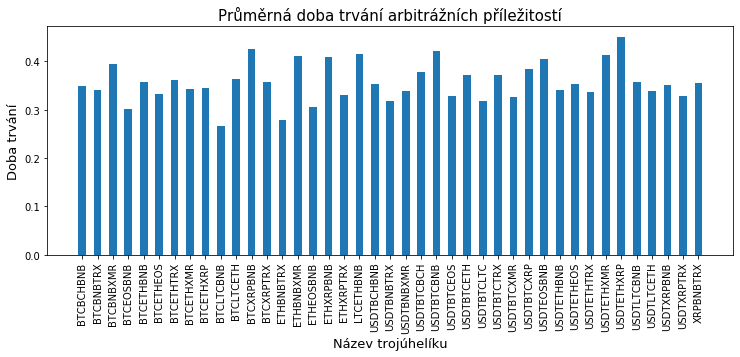

In [14]:
averages = [np.nanmean(x) for x in deltatimes_by_currency.values()]
names = list(deltatimes_by_currency.keys())
deltatime_averages_by_currency = {}
for i in range(len(deltatimes_by_currency)):
    deltatime_averages_by_currency[names[i]] = averages[i]

fig, ax = plt.subplots()
width = 0.5
ax.bar(range(len(deltatime_averages_by_currency)), deltatime_averages_by_currency.values(), align='center', width=width)
fig.set_size_inches(width * len(deltatime_averages_by_currency.keys()) * 0.6, 7*0.6)
plt.xticks(range(len(deltatime_averages_by_currency)), list(deltatime_averages_by_currency.keys()))
plt.xticks(rotation=90)
plt.xlabel('Název trojúhelíku', fontsize=label_font_size)
plt.ylabel('Doba trvání', fontsize=label_font_size)
plt.title('Průměrná doba trvání arbitrážních příležitostí', fontsize=15)
plt.savefig(os.path.join('images/deltatime_distribution.png'), dpi=300, format='png')
plt.show()

**Výpočet průměru a mediánu trvání arbitrážních příležitostí.**

In [15]:
deltatime_average = np.nanmean(flatten(deltatimes_by_currency.values()))
deltatime_median = np.median(flatten(deltatimes_by_currency.values()))
print("Průměrná doba trvání arbitrážní příležitosti je:", deltatime_average)
print("Medián doby trvání arbitrážní příležitosti je:", deltatime_median)

Průměrná doba trvání arbitrážní příležitosti je: 0.35388211063728275
Medián doby trvání arbitrážní příležitosti je: 0.25168759995


## Hours and weekday distribution

In [16]:
hours_counter = Counter()    

stats = []
for directory in fetch_directories(path):
    triangle = Triangle(fetch_files(directory), directory, directory[len(path):])
    counter = triangle.time_distribution_by_hours()
    hours_counter += counter
    triangle = None

**Vykreslení grafu rozdělení arbitrážních příležitostí na základě hodiny vzniku**

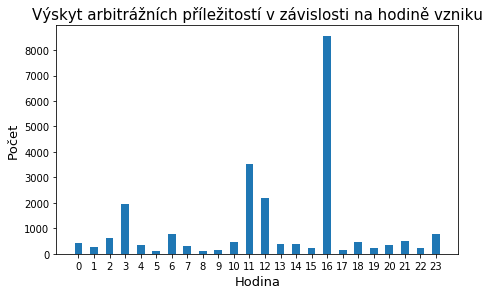

In [17]:
fig, ax = plt.subplots()
ind = np.arange(len(hours_counter))
width = 0.5
ax.bar(ind, hours_counter.values(), width=width)
fig.set_size_inches(width * len(hours_counter.keys()) * 0.6, 7*0.6)
ax.set_xticks(ind)
plt.xlabel('Hodina', fontsize=label_font_size)
plt.ylabel('Počet', fontsize=label_font_size)

plt.title('Výskyt arbitrážních příležitostí v závislosti na hodině vzniku', fontsize=15)
plt.savefig(os.path.join('images/hours_distribution.png'), dpi=300, format='png')
plt.show()

In [18]:
weekday_counter = Counter()

for directory in fetch_directories(path):
    triangle = Triangle(fetch_files(directory), directory, directory[len(path):])
    counter = triangle.time_distribution_by_weekdays()
    weekday_counter += counter
    triangle = None

**Vykreslení grafu rozdělení arbitrážních příležitostí na základě vzniku v dni v týdnu**

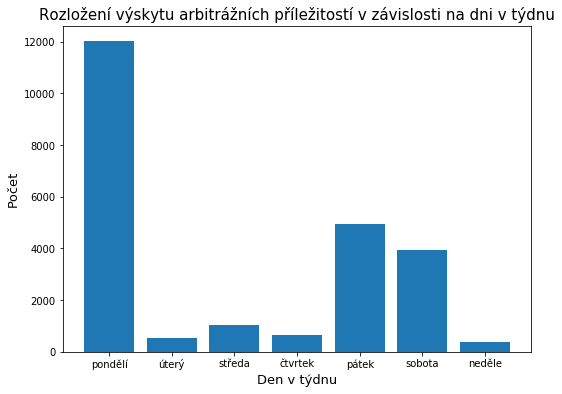

In [19]:
weekdays = ['pondělí', 'úterý', 'středa', 'čtvrtek', 'pátek', 'sobota', 'neděle']

fig, ax = plt.subplots()
ind = weekdays
width = 0.8
ax.bar(ind, weekday_counter.values(), width=width)
fig.set_size_inches(width * len(weekday_counter.keys()) * 1.5, 6)
ax.set_xticks(ind)
plt.xlabel('Den v týdnu', fontsize=label_font_size)
plt.ylabel('Počet', fontsize=label_font_size)
plt.title('Rozložení výskytu arbitrážních příležitostí v závislosti na dni v týdnu', fontsize=title_font_size - 5)

plt.savefig(os.path.join('images/weekday_distribution.png'), dpi=300, format='png')
plt.show()

## Days distribution

**Vykreslení různých grafů na porovnání celkového počtu transakcí, neefektivit trhu a arbitrážních příležitostí.**

In [20]:
arbitrages_counter = Counter()
without_fees_counter = Counter()
all_counter = Counter()
for directory in fetch_directories(path):
    triangle = Triangle(fetch_files(directory), directory, directory[len(path):])
    arbitrages_counts, without_fees_count, all_count, dates = triangle.get_arbitrages_counts()
    for i in range(len(dates)):
        arbitrages_counter[dates[i]] += arbitrages_counts[i]
        without_fees_counter[dates[i]] += without_fees_count[i]
        all_counter[dates[i]] += all_count[i]

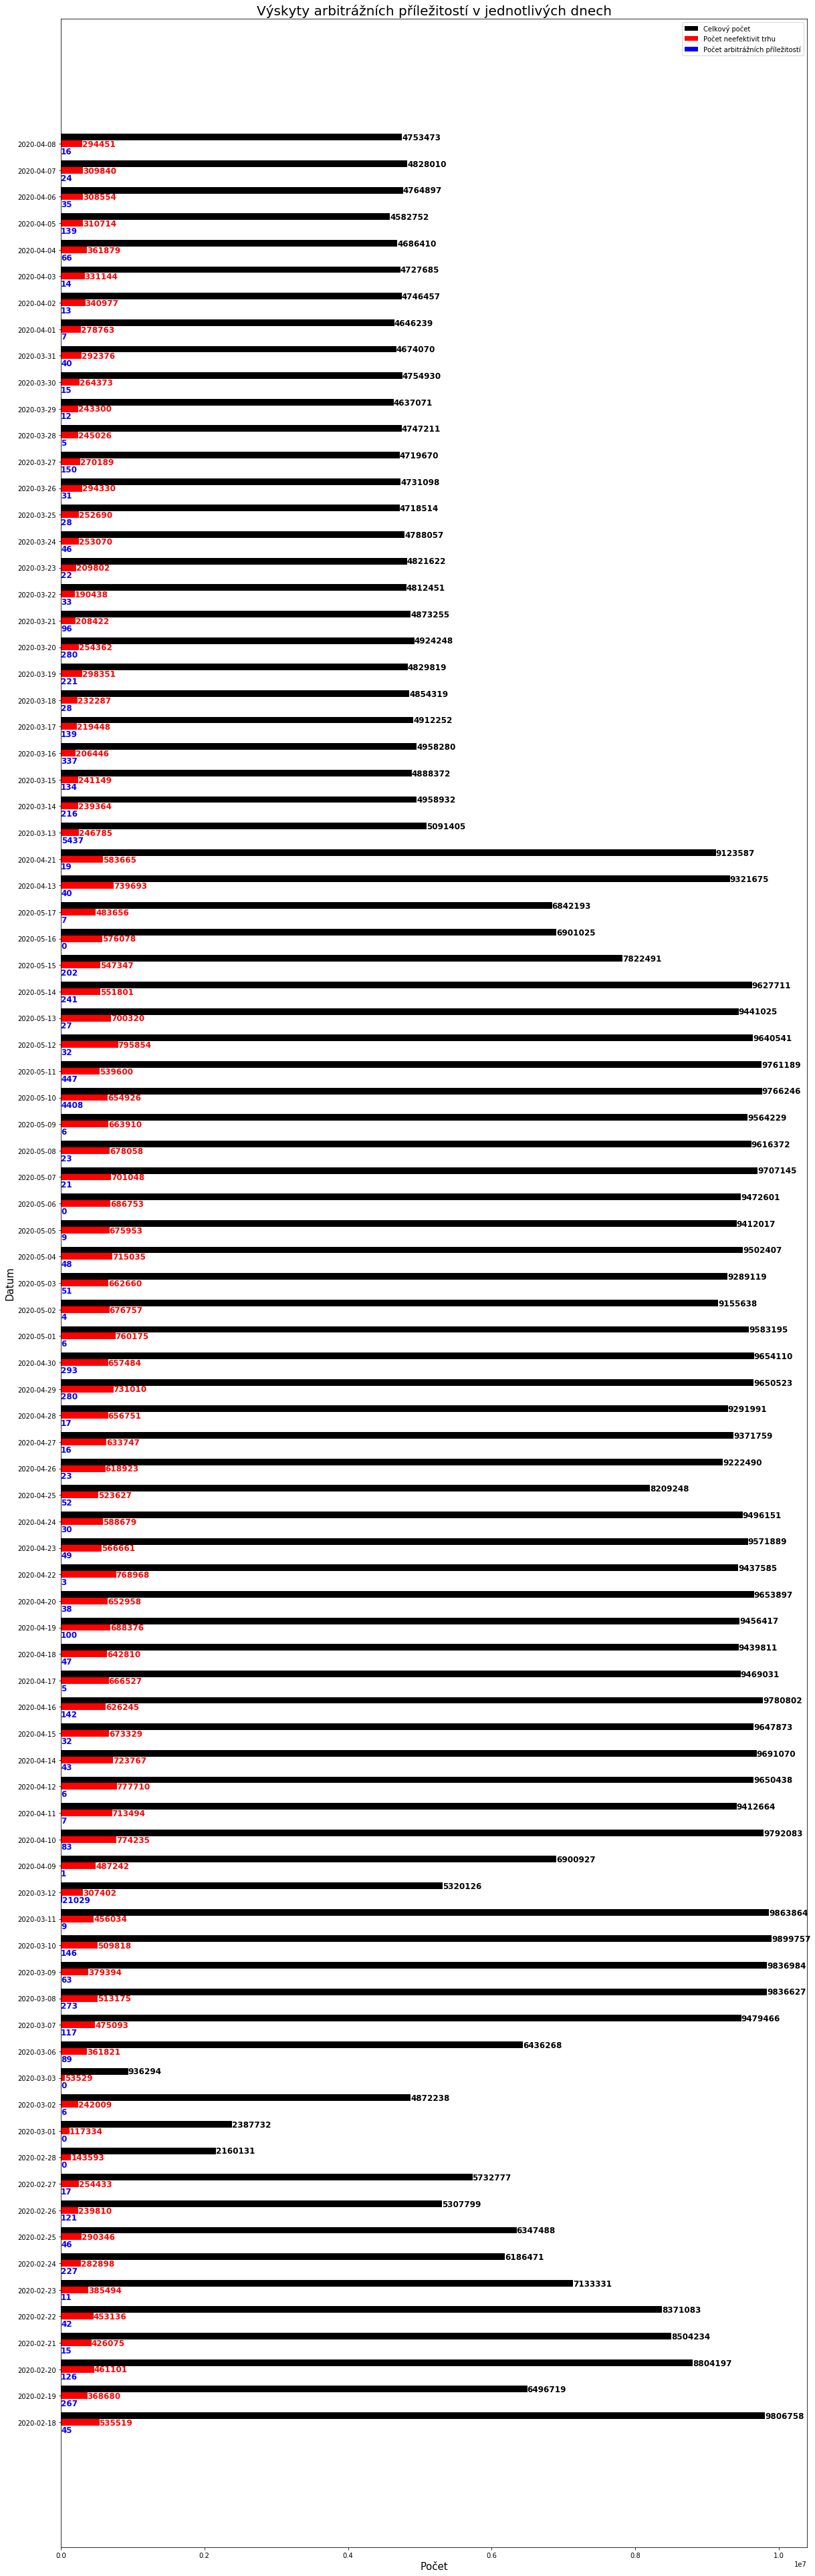

In [21]:
fig, ax = plt.subplots()    
width = 0.25  # the width of the bars 
color = 'black'  # text color
ind = np.arange(len(arbitrages_counter))  # the x locations for the groups
ax.barh(np.arange(len(arbitrages_counter)) + width, all_counter.values(), height=width, align='center', color='black', label='Celkový počet')
ax.barh(np.arange(len(arbitrages_counter)), without_fees_counter.values(), height=width, align='center', color='red', label='Počet neefektivit trhu')
ax.barh(np.arange(len(arbitrages_counter)) - width, arbitrages_counter.values(), height=width, align='center', color='blue', label='Počet arbitrážních příležitostí')
ax.set_yticks(ind)
ax.set_yticklabels(arbitrages_counter.keys())
plt.xlabel("Počet", fontsize=15)
plt.ylabel("Datum", fontsize=15)
plt.title("Výskyty arbitrážních příležitostí v jednotlivých dnech", fontsize=title_font_size)
ax.legend()
fig.set_size_inches(20, width*3.2*len(arbitrages_counter.keys()))
for i, v in enumerate(all_counter.values()):
    ax.text(v, i + width*0.6, str(v), color='black', fontweight='bold', fontsize=12)
for i, v in enumerate(without_fees_counter.values()):
    ax.text(v, i - width*0.4, str(v), color='red', fontweight='bold', fontsize=12)
for i, v in enumerate(arbitrages_counter.values()):
    ax.text(v, i - width*1.5, str(v), color='blue', fontweight='bold', fontsize=12)
plt.savefig(os.path.join('images/occurences_full.png'), dpi=300, format='png')
plt.show()

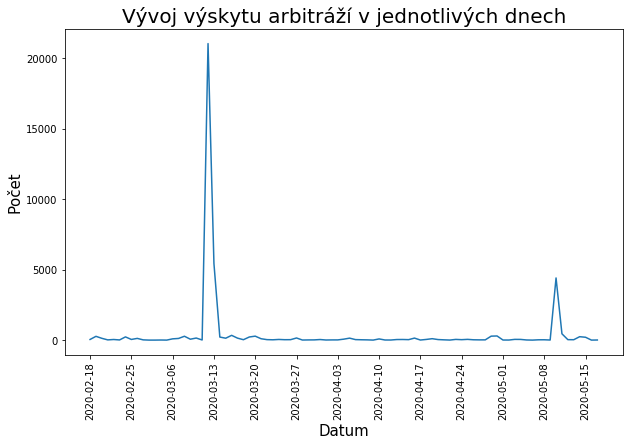

In [22]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.plot(*zip(*sorted(arbitrages_counter.items())))
ax.set_xticks(range(0, len(arbitrages_counter), 7))
plt.xticks(rotation=90)
plt.ylabel("Počet", fontsize=15)
plt.xlabel("Datum", fontsize=15)
plt.title('Vývoj výskytu arbitráží v jednotlivých dnech', fontsize=title_font_size)
plt.savefig(os.path.join('images/occurences.png'), dpi=300, format='png')
plt.show()

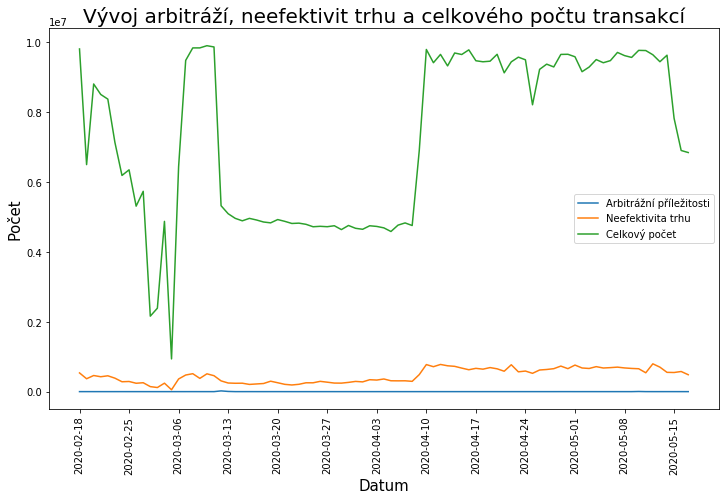

In [23]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 7)
ax.plot(*zip(*sorted(arbitrages_counter.items())), label='Arbitrážní příležitosti')
ax.plot(*zip(*sorted(without_fees_counter.items())), label='Neefektivita trhu')
ax.plot(*zip(*sorted(all_counter.items())), label='Celkový počet')
ax.set_xticks(range(0, len(arbitrages_counter), 7))
ax.legend()
plt.xticks(rotation=90)
plt.ylabel("Počet", fontsize=15)
plt.xlabel("Datum", fontsize=15)
plt.title('Vývoj arbitráží, neefektivit trhu a celkového počtu transakcí', fontsize=title_font_size)
plt.savefig(os.path.join('images/occurence_correlation.png'), dpi=300, format='png')
plt.show()

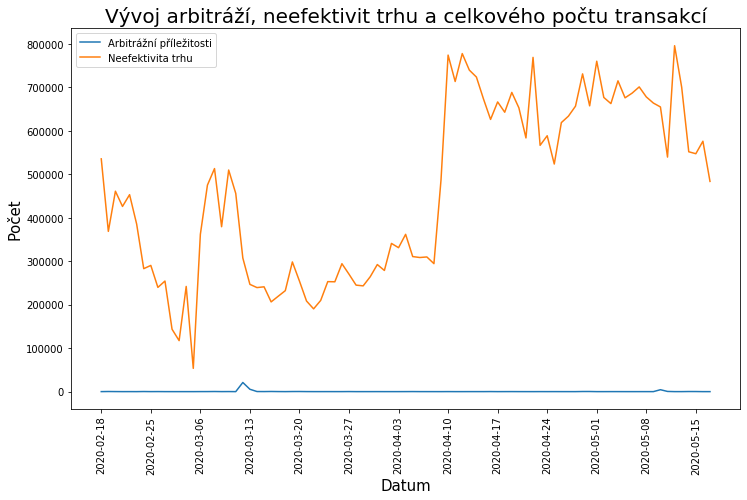

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 7)
ax.plot(*zip(*sorted(arbitrages_counter.items())), label='Arbitrážní příležitosti')
ax.plot(*zip(*sorted(without_fees_counter.items())), label='Neefektivita trhu')
ax.set_xticks(range(0, len(arbitrages_counter), 7))
ax.legend()
plt.xticks(rotation=90)
plt.ylabel("Počet", fontsize=15)
plt.xlabel("Datum", fontsize=15)
plt.title('Vývoj arbitráží, neefektivit trhu a celkového počtu transakcí', fontsize=title_font_size)
plt.savefig(os.path.join('images/ineffictivity_correlation.png'), dpi=300, format='png')
plt.show()

## Pearson's correlation coeficients

**Pearsonovy korelační koeficienty mezi výskytem arbitrážních příležitostí a výskytem neefektivit na trhu.**

In [25]:
correlation, p_value = scipy.stats.pearsonr(list(arbitrages_counter.values()), list(all_counter.values()))
print('Korelační koeficient mezi výskytem arbitrážních příležitostí a počtem provedených obchodů je', correlation)
correlation, p_value = scipy.stats.pearsonr(list(arbitrages_counter.values()), list(without_fees_counter.values()))
print('Korelační koeficient mezi výskytem arbitrážních příležitostí a počtem neefektivit trhu je', correlation)

Korelační koeficient mezi výskytem arbitrážních příležitostí a počtem provedených obchodů je -0.08479839816807584
Korelační koeficient mezi výskytem arbitrážních příležitostí a počtem neefektivit trhu je -0.08959759898226355


## Index distribution

**Získání dat a vykreslení koláčového grafu rozložení indexů udávajících nejlepší absolutní zisk.**

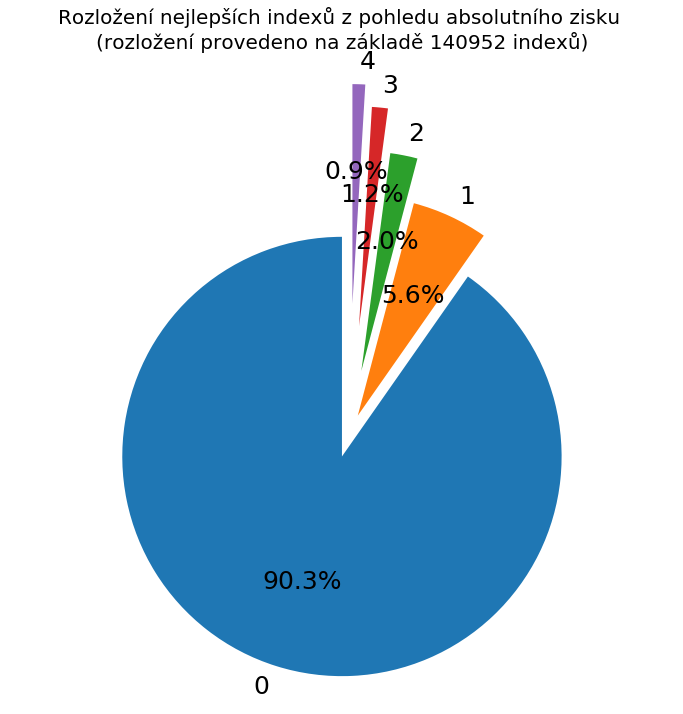

In [26]:
indexes = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
count = 0
for directory in fetch_directories(path):
    triangle = Triangle(fetch_files(directory), directory, directory[len(path):])
    ind = triangle.get_best_indexes_count()
    for k in ind.keys():
        indexes[k] += ind[k]
    triangle = None
        
labels = indexes.keys()
sizes = indexes.values()
explode = (0.1, 0.1, 0.3, 0.5, 0.6)
fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=False, startangle=90, textprops={'fontsize': 25})
ax.axis('equal')
fig.set_size_inches(12, 12)
plt.title("Rozložení nejlepších indexů z pohledu absolutního zisku \n(rozložení provedeno na základě " 
              + str(sum(indexes.values())) + " indexů)", fontsize=title_font_size)

plt.savefig(os.path.join('images/index_distribution.png'), dpi=300, format='png')
    
plt.show()

## Basic stats table

**Vypsání tabulky základních statistik pro všechny trojúhelníky**

stats = []
for directory in fetch_directories(path):
    triangle = Triangle(fetch_files(directory), directory, directory[len(path):])
    stats.append(basic_stats(triangle))
    triangle = None

In [27]:
stats = []
for directory in fetch_directories(path):
    triangle = Triangle(fetch_files(directory), directory, directory[len(path):])
    with warnings.catch_warnings():
        # nanmean throws a warning when a np.Nan is contained in an array
        warnings.simplefilter("ignore", category=RuntimeWarning)
        stats.append(basic_stats(triangle))
    triangle = None

In [28]:
pd.options.display.float_format = "{:f}".format
stats_table = pd.DataFrame(stats)
stats_table

,Name,Formatted_name,Days,Average count,Average score,The best score,The best gain,Total inefficiency,Average daily inefficiency,Average daily inefficiency (USD)
0,BTCBCHBNB,BTC/BCH/BNB,58,1.965517,1.000346,1.014323,"0,044034 BCH","0,079688 BCH","0,004686 BCH",1.044816
1,BTCBNBTRX,BTC/BNB/TRX,60,0.566667,1.000122,1.010272,"711,834653 TRX","2068,181090 TRX","37,669655 TRX",0.474525
2,BTCBNBXMR,BTC/BNB/XMR,58,2.896552,1.000156,1.016683,"0,023207 XMR","0,234113 XMR","0,004210 XMR",0.224689
3,BTCEOSBNB,BTC/EOS/BNB,60,0.833333,1.000140,1.007323,"0,411366 EOS","1,003971 EOS","0,027397 EOS",0.066850
4,BTCETHBNB,BTC/ETH/BNB,60,1.083333,1.000265,1.008531,"2,168246 BNB","3,166405 BNB","0,089227 BNB",1.385699
5,BTCETHEOS,BTC/ETH/EOS,58,0.758621,1.000141,1.005868,"1,137435 EOS","3,315197 EOS","0,131114 EOS",0.319919
6,BTCETHTRX,BTC/ETH/TRX,87,2.126437,1.000167,1.039214,"6691,163452 TRX","13378,217688 TRX","194,088264 TRX",2.444930
7,BTCETHXMR,BTC/ETH/XMR,85,8.152941,1.000282,1.014078,"0,150716 XMR","1,267977 XMR","0,018077 XMR",0.964752
8,BTCETHXRP,BTC/ETH/XRP,87,5.160920,1.000270,1.019007,"76,373134 XRP","789,647149 XRP","18,530255 XRP",3.445979
9,BTCLTCBNB,BTC/LTC/BNB,60,0.866667,1.000154,1.008470,"0,129114 LTC","0,189401 LTC","0,005206 LTC",0.213432


## Latex table creation

In [29]:
condition = stats_table['Average daily inefficiency (USD)'] > 10
stats_table[condition]

,Name,Formatted_name,Days,Average count,Average score,The best score,The best gain,Total inefficiency,Average daily inefficiency,Average daily inefficiency (USD)
19,USDTBCHBNB,USDT/BCH/BNB,85,19.376471,1.001023,1.105397,"2,086942 BCH","29,767377 BCH","0,381556 BCH",85.079456
21,USDTBNBXMR,USDT/BNB/XMR,85,28.941176,1.000668,1.129565,"9,045483 XMR","172,961447 XMR","2,072639 XMR",110.616732
22,USDTBTCBCH,USDT/BTC/BCH,60,4.633333,1.000798,1.030769,"0,611238 BCH","1,665887 BCH","0,080214 BCH",17.886043
23,USDTBTCBNB,USDT/BTC/BNB,60,7.016667,1.000741,1.011737,"4,113515 BNB","33,568239 BNB","1,335634 BNB",20.742392
24,USDTBTCEOS,USDT/BTC/EOS,87,13.367816,1.000623,1.073843,"95,706220 EOS","3782,855087 EOS","48,942284 EOS",119.419172
25,USDTBTCETH,USDT/BTC/ETH,60,3.683333,1.000626,1.023912,"0,766488 ETH","2,339062 ETH","0,127004 ETH",19.901603
26,USDTBTCLTC,USDT/BTC/LTC,87,12.908046,1.000475,1.041514,"7,111574 LTC","190,036518 LTC","2,433303 LTC",99.765406
27,USDTBTCTRX,USDT/BTC/TRX,87,6.321839,1.000565,1.081229,"35482,621400 TRX","633522,316781 TRX","8341,144951 TRX",105.073403
28,USDTBTCXMR,USDT/BTC/XMR,87,20.413793,1.000715,1.059456,"2,589395 XMR","77,183713 XMR","0,996903 XMR",53.204728
29,USDTBTCXRP,USDT/BTC/XRP,87,14.402299,1.000528,1.057943,"1226,628320 XRP","42181,675238 XRP","567,311008 XRP",105.499992


In [30]:
def list_of_dicts_to_latex_table(table: [dict], caption: str, float_format='{:.4f}', label=None):
    '''
    Takes a list of dictionaries and translates it into Latex table compatible with CTU template
    table -> the content table to be translated into Latex
    caption -> caption of the Latex table
    float_format -> format in which to output the decimal numers
    label -> label of the Latex table, if None than no lable is created
    '''
    output = '\\begin{table}\\centering\n'
    output += '\\caption{' + caption + '}\n'
    if label is not None:
        output += '\\label{' + str(label) + '}\n'
    output += '\\begin{tabular}{||'
    tmp = '\\hline '
    keys = list(table[0].keys())
    for key in keys:
        output += ' r |'
        if key == keys[-1]:
            tmp += str(key) + '\\\\ [0.5ex]' + '\n '        
        else:
            tmp += key + ' & '
    output += '|}'
    output += tmp + '\\hline'
    for row in table:
        output += '\\hline '
        column_names = list(row.values())
        for column in column_names:
            if column == column_names[-1]:
                if isinstance(column, float):
                    output += (float_format.format(column)).replace(".", ",") + '\\\\ ' + '\n '
                else:
                    output += str(column) + '\\\\ ' + '\n '
            else:
                if isinstance(column, float):
                    output += (float_format.format(column)).replace(".", ",") + ' & '
                else:
                    output += str(column) + ' & '
    output += '\\hline\n'
    output += '\\end{tabular}\n'
    output += '\\end{table}'
    return output


In [31]:
def dict_to_latex_table(table:  Dict[any, any], caption: str, float_format='{:.4f}', label=None, column_names=('items, values')):
    '''
    Takes a dictionary and translates it into Latex table compatible with CTU template
    table -> the content table to be translated into Latex
    caption -> caption of the Latex table
    float_format -> format in which to output the decimal numers
    label -> label of the Latex table, if None than no lable is created
    column_names -> a tuple representing column names (expected length is 2)
    '''
    output = '\\begin{table}\\centering\n'
    output += '\\caption{' + caption + '}\n'
    if label is not None:
        output += '\\label{' + str(label) + '}\n'  
    keys = list(table.keys())
    output += '\\begin{tabular}{|| l | r ||}\n'
    output += '\\hline ' + str(column_names[0]) + ' & ' + str(column_names[1]) + ' \\\\ \n'
    output += '\\hline'
    for key, val in table.items():
        output += '\\hline ' + str(key) + ' & ' + str(val).replace(".", ",") + ' \\\\ \n'
    output += '\\hline\n'
    output += '\\end{tabular}\n'
    output += '\\end{table}'
    return output

**Různé tabulky přeložené do Latexu.**

In [32]:
caption = 'Tabulka porovnávající průměrné denní počty a~průměrné neefektivity jednotlivých trojúhelníků'
output_file_name = 'output_files/table_average.tex'
label = 'table_averages'
f = open(output_file_name, "wb")

df = stats_table[['Formatted_name', 'Average count', 'Average score']]
df.columns = ('Trojúhelník', 'Průměrný denní počet', 'Průměrná \% neefektivita')
# df = df.drop([3, 7])
stats_dict = df.to_dict('records')
f.write(list_of_dicts_to_latex_table(stats_dict, caption, label=label).encode('utf8'))
f.close()

In [33]:
caption = 'Tabulka potenciálních výnosů arbitrážních příležitostí na~jednotlivých trojúhelnících'
output_file_name = 'output_files/table_gain.tex'
label = 'table_gains'
f = open(output_file_name, "wb")


df = stats_table[['Formatted_name', 'Average daily inefficiency', 'Average daily inefficiency (USD)']]
df.columns = ('Trojúhelník', 'Denní neefektivita', 'Denní neefektivita (USD)')
# df = df.drop([3, 7])
stats_dict = df.to_dict('records')
f.write(list_of_dicts_to_latex_table(stats_dict, caption, float_format='{:f}', label=label).encode('utf8'))
f.close()

In [34]:
caption = 'Tabulka potenciálního výnosu arbitrážních příležitostí na nejlepších trojúhelnících'
output_file_name = 'output_files/table_gain_best.tex'
label = 'table_gains_best'
f = open(output_file_name, "wb")

df = stats_table[condition]
df = df[['Formatted_name', 'Average daily inefficiency', 'Average daily inefficiency (USD)']]
df.columns = ('Trojúhelník', 'Denní neefektivita', 'Denní neefektivita (USD)')
stats_dict = df.to_dict('records')
f.write(list_of_dicts_to_latex_table(stats_dict, caption, float_format='{:e}', label=label).encode('utf8'))
f.close()

In [35]:
caption = 'Tabulka průměrných hodnot týkajících se arbitrážních příležitostí na nejlepších trojúhelnících'
output_file_name = 'output_files/table_average_best.tex'
label = 'table_averages_best'
f = open(output_file_name, "wb")

df = stats_table[condition]
df = df[['Formatted_name', 'Average count', 'Average score']]
df.columns = ('Trojúhelník', 'Průměrný denní počet', 'Průměrná \% neefektivita')
stats_dict = df.to_dict('records')
f.write(list_of_dicts_to_latex_table(stats_dict, caption,float_format='{:f}', label=label).encode('utf8'))
f.close()

In [36]:
caption = 'Tabulka průměrných hodnot týkajících se arbitrážních příležitostí na nejlepších trojúhelnících'
output_file_name = 'output_files/table_combined_best.tex'
label = 'table_combined_best'
f = open(output_file_name, "wb")

df = stats_table[condition]
df = df[['Formatted_name', 'Average count', 'Average daily inefficiency (USD)']]
df.columns = ('Trojúhelník', 'Průměrný denní počet', 'Denní neefektivita (USD)')
df = df.sort_values('Denní neefektivita (USD)', ascending=False)
stats_dict = df.to_dict('records')
f.write(list_of_dicts_to_latex_table(stats_dict, caption,float_format='{:f}', label=label).encode('utf8'))
f.close()

In [37]:
caption = 'Tabulka kurzů využitých na přepočet na americké dolary (údaj z burzy Binance ze dne 13.4.2020)'
output_file_name = 'output_files/table_rates.tex'
label = 'table_rates'
f = open(output_file_name, "wb")

f.write(dict_to_latex_table(rate, caption, label=label, float_format='{:.2f}', column_names=('Kryptoměna', 'Kurz na USD')).encode('utf8'))
f.close()

## Arbitrage stat charts for every triangle

**Creates a bar chart for every triangle which shows the arbitrages counts, market inefficiencies and total number of transactions.**

In [38]:
# Charts creationg is too slow. Set 'create_bar_charts' to 'True' for drawing all the charts.
create_bar_charts = False
if create_bar_charts:
    tr = None
    for directory in fetch_directories(path):
        triangle = Triangle(fetch_files(directory), directory, directory[len(path):])
        arbitrages_counts, without_fees_count, all_count, dates = triangle.get_arbitrages_counts()

        # ---------------------------------------- plot
        fig, ax = plt.subplots()    
        width = 0.25  # the width of the bars 
        color = 'black'  # text color
        ind = np.arange(len(arbitrages_counts))  # the x locations for the groups
        ax.barh(np.arange(len(arbitrages_counts)) + width, all_count, height=width, align='center', color='black', label='Celkový počet')
        ax.barh(np.arange(len(arbitrages_counts)), without_fees_count, height=width, align='center', color='red', label='Počet neefektivit trhu')
        ax.barh(np.arange(len(arbitrages_counts)) - width, arbitrages_counts, height=width, align='center', color='blue', label='Počet arbitrážních příležitostí')
        ax.set_yticks(ind)
        ax.set_yticklabels(dates)
        plt.xlabel("Počet", fontsize=15)
        plt.ylabel("Datum", fontsize=15)
        plt.title("Výskyty příležitostí v jednotlivých dnech na trojúhelníku " + triangle.name, fontsize=title_font_size)
        ax.legend()
        fig.set_size_inches(18.5, width*3.2*len(dates))
        for i, v in enumerate(all_count):
            ax.text(v, i + width*0.6, str(v), color='black', fontweight='bold', fontsize=12)
        for i, v in enumerate(without_fees_count):
            ax.text(v, i - width*0.4, str(v), color='red', fontweight='bold', fontsize=12)
        for i, v in enumerate(arbitrages_counts):
            ax.text(v, i - width*1.5, str(v), color='blue', fontweight='bold', fontsize=12)
        plt.savefig(os.path.join('arbitrages_count/' + triangle.name + '.png'), dpi=300, format='png')
        plt.show()
        # !---------------------------------------- plot

In [39]:
def bar_plot_from_pandas_dataframe(df, x: str, y: str, title='Nadpis', color='C0', save=False, output_name='chart', output_directory='./'):
    '''
    Creates a bar plot from a Pandas DataFrame
    df -> dataframe
    x -> label of x axis
    y -> label of y axis
    title -> chart title
    color -> color of the bars 
    save -> bool, whether the chart is to be saved 
    output_name -> output name of the chart if "save" option is set to True
    output_directory -> name of the directory where the chart is to be saved if parameter "save" is set to True
    '''
    fig, ax = plt.subplots()
    df.plot(kind='bar', x=x, y=y, ax=ax, color=color)
    width = 0.3
    plt.title(title, fontsize=title_font_size)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.xlabel("Název", fontsize=label_font_size)
    fig.set_size_inches(width * len(df['Average count']), 12)
    plt.tight_layout()
    if save:
        plt.savefig(os.path.join(output_directory + output_name + '.png'), dpi=300, format='png')
    plt.show()

**Různé sloupcové grafy pro statistiky z hlavní tabulky statistik (stats_table)**

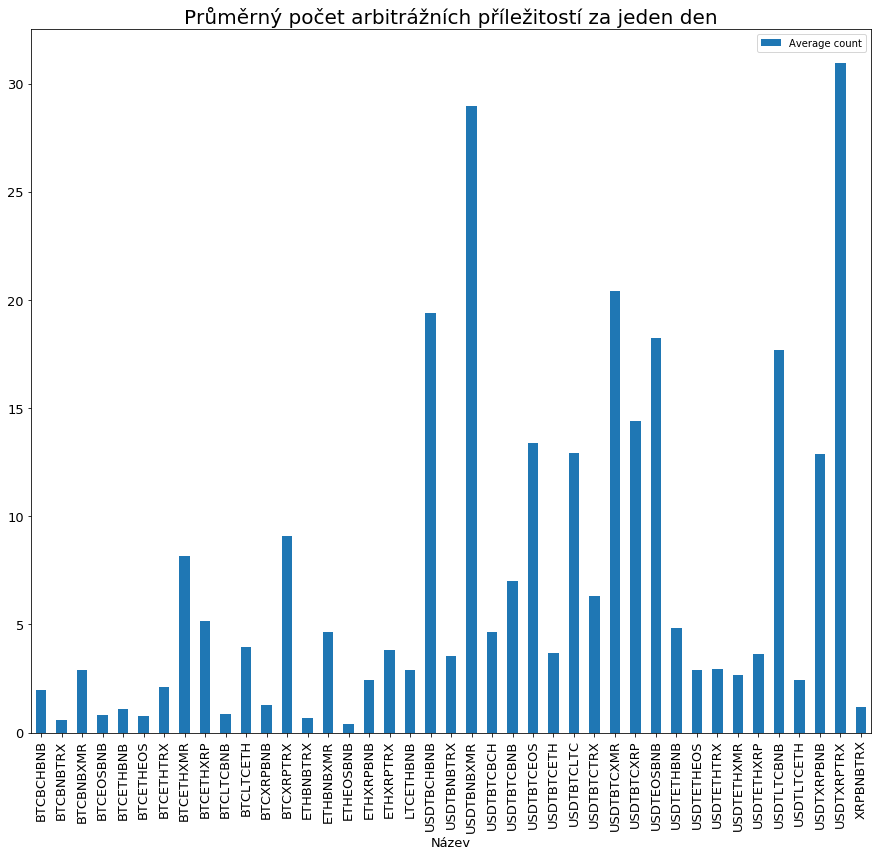

In [40]:
bar_plot_from_pandas_dataframe(stats_table, 'Name', 'Average count', "Průměrný počet arbitrážních příležitostí za jeden den", 
                               save=True, output_name='average_count', output_directory='./images/')

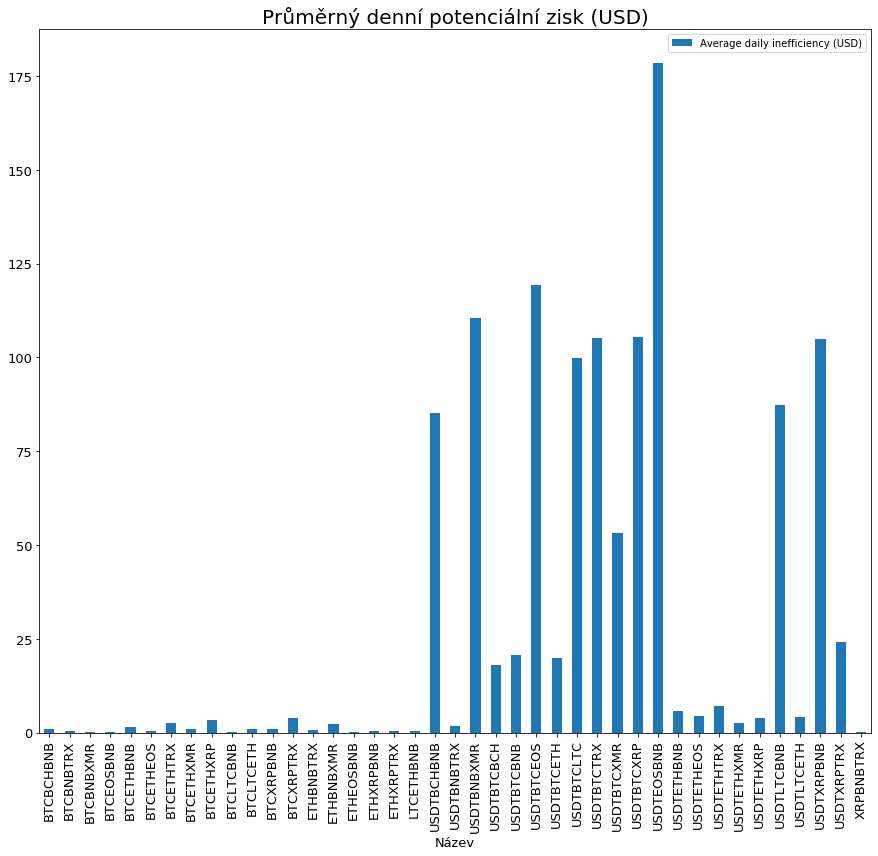

In [41]:
bar_plot_from_pandas_dataframe(stats_table, 'Name', 'Average daily inefficiency (USD)', "Průměrný denní potenciální zisk (USD)",
                              save=True, output_name='average_daily_inefficiency', output_directory='./images/')

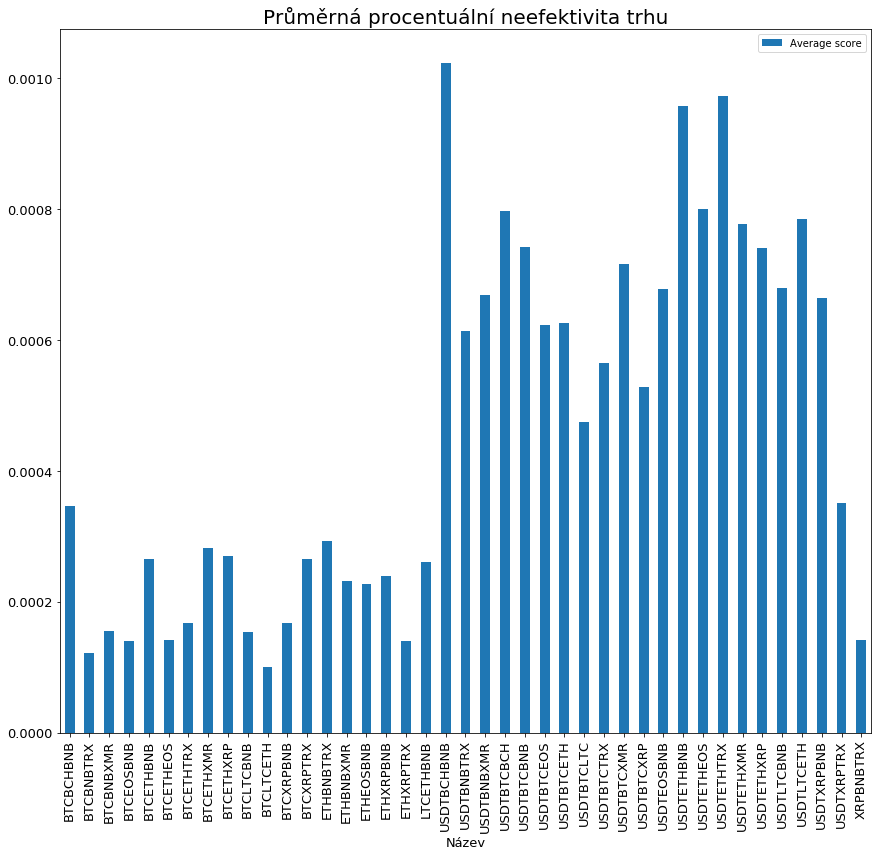

In [42]:
df = deepcopy(stats_table)
df['Average score'] = df['Average score'].apply(lambda x: x - 1)
bar_plot_from_pandas_dataframe(df, 'Name', 'Average score', "Průměrná procentuální neefektivita trhu",
                              save=True, output_name='average_percentage_inefficiency', output_directory='./images/')
df = None

## Specific statistics to the best triangles

**Nastavení podmínky pro výběr trojúhelníků pro práci v celé sekci**

In [43]:
# cond = [True]*len(stats_table)  # a condition selection all rows
cond = stats_table['Average daily inefficiency (USD)'] > 10
stats_table[cond]

,Name,Formatted_name,Days,Average count,Average score,The best score,The best gain,Total inefficiency,Average daily inefficiency,Average daily inefficiency (USD)
19,USDTBCHBNB,USDT/BCH/BNB,85,19.376471,1.001023,1.105397,"2,086942 BCH","29,767377 BCH","0,381556 BCH",85.079456
21,USDTBNBXMR,USDT/BNB/XMR,85,28.941176,1.000668,1.129565,"9,045483 XMR","172,961447 XMR","2,072639 XMR",110.616732
22,USDTBTCBCH,USDT/BTC/BCH,60,4.633333,1.000798,1.030769,"0,611238 BCH","1,665887 BCH","0,080214 BCH",17.886043
23,USDTBTCBNB,USDT/BTC/BNB,60,7.016667,1.000741,1.011737,"4,113515 BNB","33,568239 BNB","1,335634 BNB",20.742392
24,USDTBTCEOS,USDT/BTC/EOS,87,13.367816,1.000623,1.073843,"95,706220 EOS","3782,855087 EOS","48,942284 EOS",119.419172
25,USDTBTCETH,USDT/BTC/ETH,60,3.683333,1.000626,1.023912,"0,766488 ETH","2,339062 ETH","0,127004 ETH",19.901603
26,USDTBTCLTC,USDT/BTC/LTC,87,12.908046,1.000475,1.041514,"7,111574 LTC","190,036518 LTC","2,433303 LTC",99.765406
27,USDTBTCTRX,USDT/BTC/TRX,87,6.321839,1.000565,1.081229,"35482,621400 TRX","633522,316781 TRX","8341,144951 TRX",105.073403
28,USDTBTCXMR,USDT/BTC/XMR,87,20.413793,1.000715,1.059456,"2,589395 XMR","77,183713 XMR","0,996903 XMR",53.204728
29,USDTBTCXRP,USDT/BTC/XRP,87,14.402299,1.000528,1.057943,"1226,628320 XRP","42181,675238 XRP","567,311008 XRP",105.499992


**Různé statistiky a grafy pro několik nejlepších trojúhelníků.**

In [44]:
# fills the best_triangles array with the triangles satisfying the condition
# defines the condition for the best triangles
df = stats_table[cond]
df = df.reset_index()
best_triangle_names = df['Name']
best_triangles = []
# goes through all of the triangles and creates a class Triangle() for everyone sutisfying the condition
for directory in fetch_directories(path):
    name = directory[len(path):]
    if name not in list(best_triangle_names):
        continue
    triangle = Triangle(fetch_files(directory), directory, directory[len(path):])
    best_triangles.append(triangle)

**Vytvoření tabulky podrobnějších statistik.**

In [45]:
def basic_stats_sort_and_rename(stats: Dict[str, any]) -> Dict[str, any]:
    tmp = {}
    tmp['Název'] = stats['Name']
    tmp['Formatted_name'] = stats['Formatted_name']
    tmp['Průměrný denní počet arbitráží'] = stats['Average count']
    tmp['Medián denního počtu arbitráží'] = stats['Median of daily number of arbitrages']
    tmp['Průměrný procentuální zisk'] = stats['Average score']
    tmp['Nejvyšší procentuální zisk'] = stats['The best score']
    tmp['Celkový potenciální zisk'] = stats['Total inefficiency']
    tmp['Celkový potenciální zisk (USD)'] = stats['Total inefficiency (USD)']
    tmp['Průměrný denní potenciální zisk'] = stats['Average daily inefficiency']
    tmp['Průměrný denní potenciální zisk (USD)'] = stats['Average daily inefficiency (USD)']
    tmp['Nejvyšší potenciální zisk'] = stats['The best gain']
    tmp['Nejvyšší potenciální zisk (USD)'] = stats['The best gain (USD)']
    tmp['Průměrná doba trvání'] = stats['Average deltatime']
    return tmp

In [46]:
best_stats = []
for triangle in best_triangles:
    with warnings.catch_warnings():
        # nanmean throws a warning when a np.Nan is contained in an array
        warnings.simplefilter("ignore", category=RuntimeWarning)
        tmp = basic_stats(triangle, float_format_e=False, full=True)
    best_stats.append(basic_stats_sort_and_rename(tmp))
best_stats

[{'Název': 'USDTBCHBNB',
  'Formatted_name': 'USDT/BCH/BNB',
  'Průměrný denní počet arbitráží': 19.376470588235293,
  'Medián denního počtu arbitráží': 2.0,
  'Průměrný procentuální zisk': 1.0010231031972445,
  'Nejvyšší procentuální zisk': 1.105396531,
  'Celkový potenciální zisk': '29,767377 BCH',
  'Celkový potenciální zisk (USD)': 6637.5296586867225,
  'Průměrný denní potenciální zisk': '0,381556 BCH',
  'Průměrný denní potenciální zisk (USD)': 85.07945599829853,
  'Nejvyšší potenciální zisk': '2,086942 BCH',
  'Nejvyšší potenciální zisk (USD)': 465.34628746955997,
  'Průměrná doba trvání': 0.3532152148134086},
 {'Název': 'USDTBNBXMR',
  'Formatted_name': 'USDT/BNB/XMR',
  'Průměrný denní počet arbitráží': 28.941176470588236,
  'Medián denního počtu arbitráží': 1.0,
  'Průměrný procentuální zisk': 1.000667765324073,
  'Nejvyšší procentuální zisk': 1.12956548,
  'Celkový potenciální zisk': '172,961447 XMR',
  'Celkový potenciální zisk (USD)': 9230.952434774776,
  'Průměrný denní po

**Uložení tabulek v Latex formátu.**

In [47]:
pd.options.display.float_format = "{:f}".format
for stats in best_stats:
    df = pd.DataFrame.from_dict(stats, orient='index')
    caption = 'Základní statistiky trojúhelníku ' + stats['Formatted_name']
    output_file_name = 'output_files/' + stats['Název'] + '.tex'
    label = stats['Název'] + '_stats'
    f = open(output_file_name, "wb")
    tmp = stats.copy()
    tmp['Název'] = tmp['Formatted_name']
    tmp.pop('Formatted_name', None)
    f.write(dict_to_latex_table(tmp, caption, label=label, column_names=('Název', 'Hodnota')).encode('utf8'))
    tmp = None
    f.close()

**Vykreslení a uložení grafů porovnávajících počet arbitráží s počtem neefektivit trhu.**

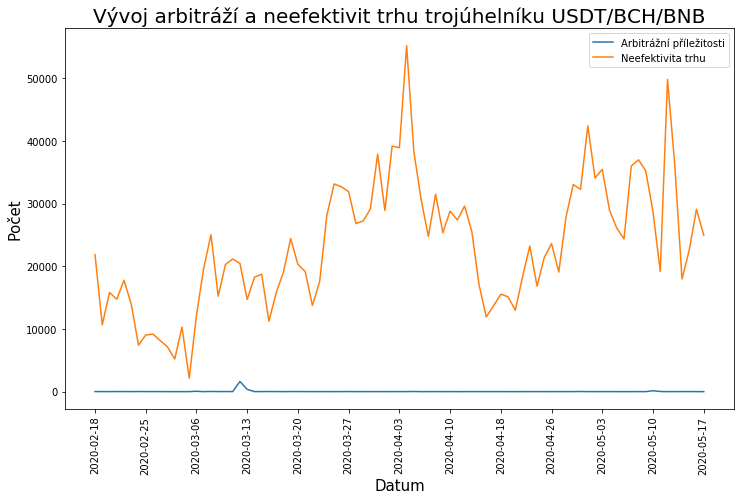

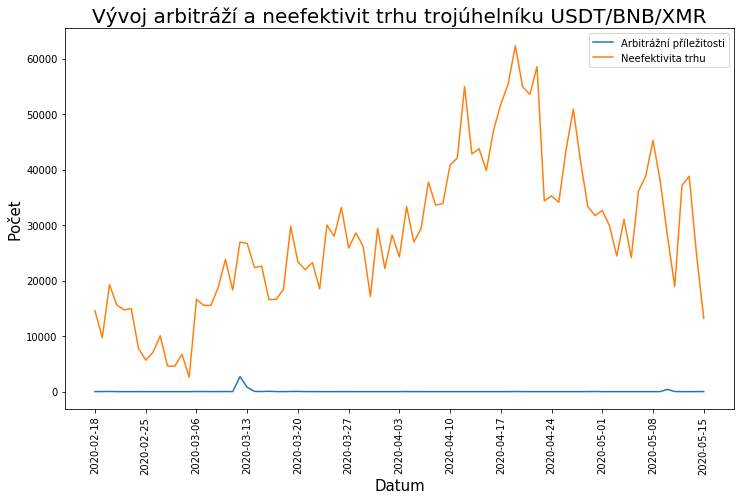

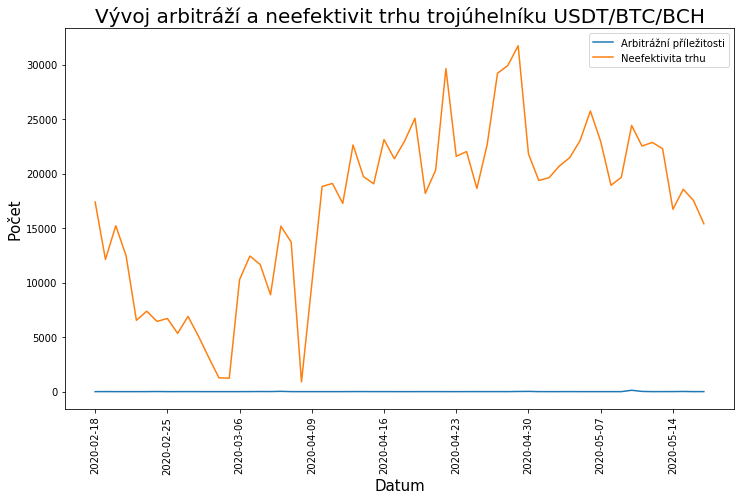

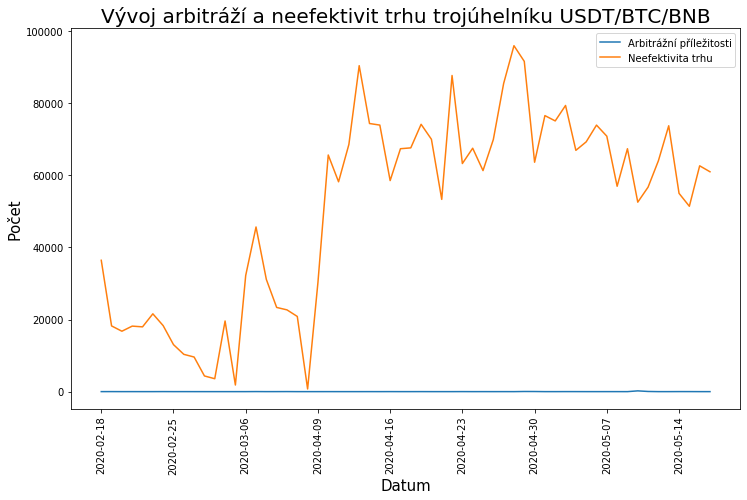

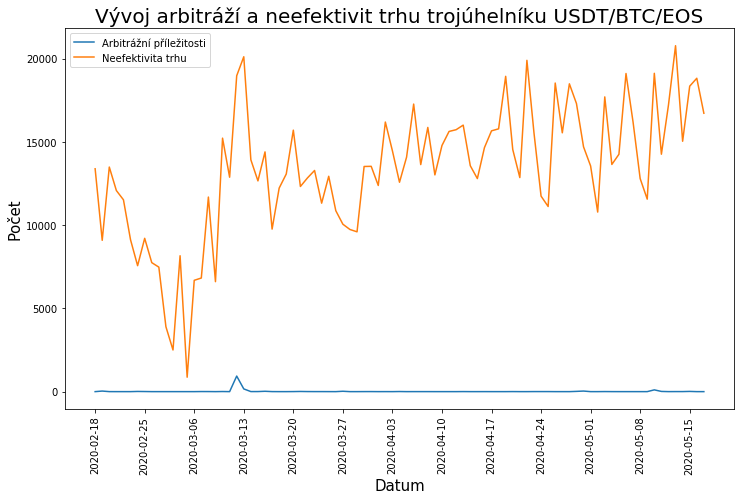

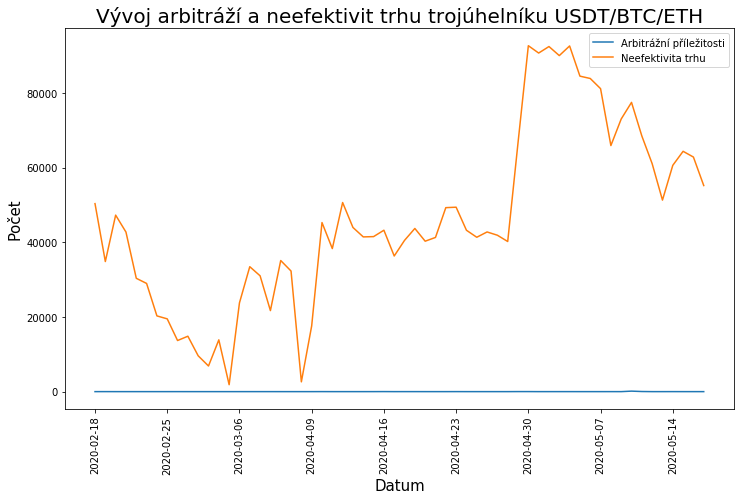

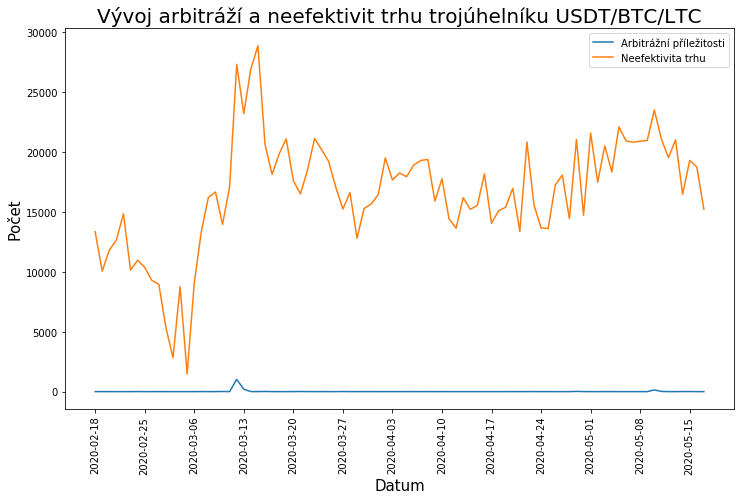

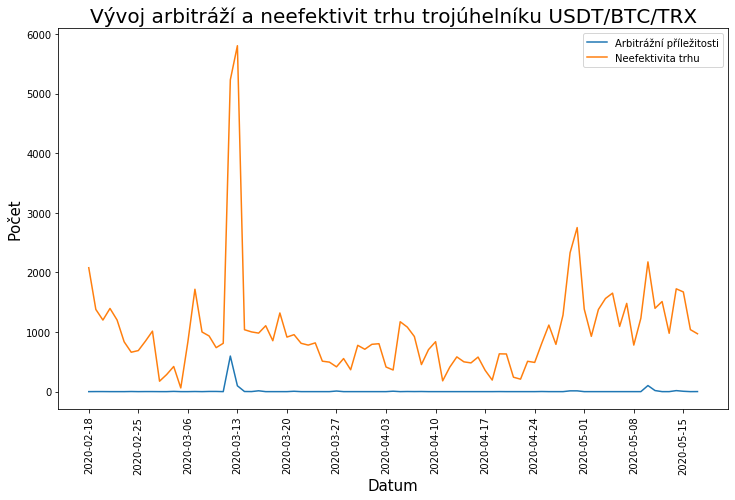

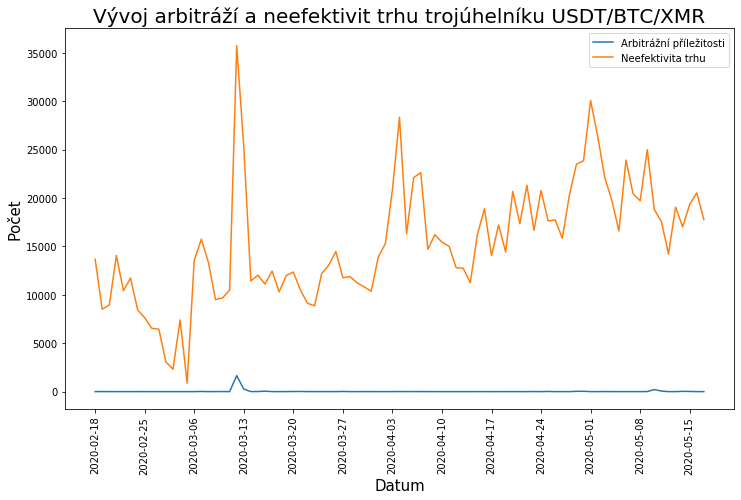

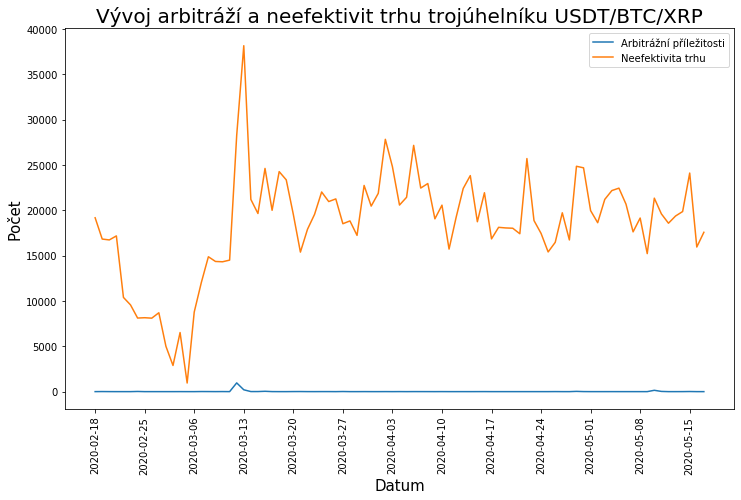

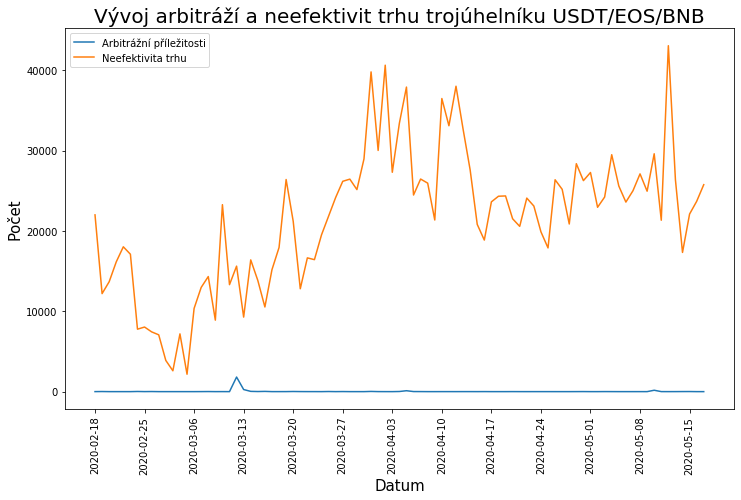

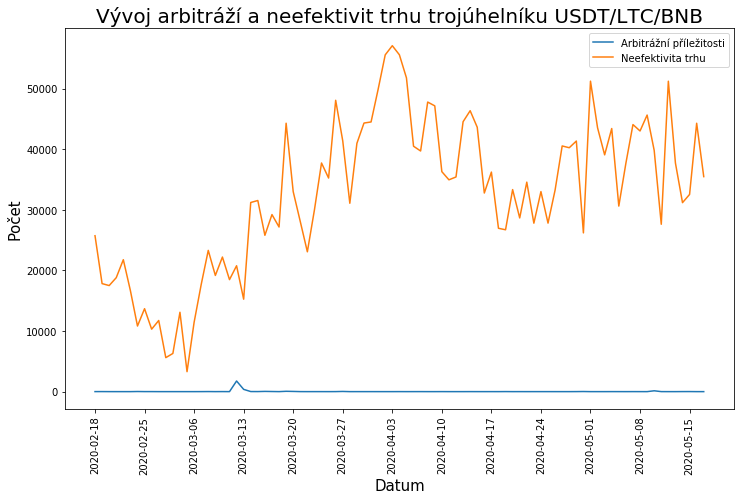

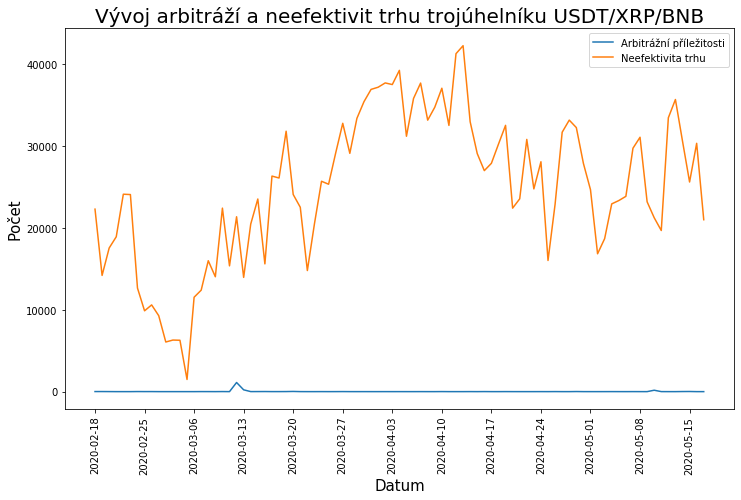

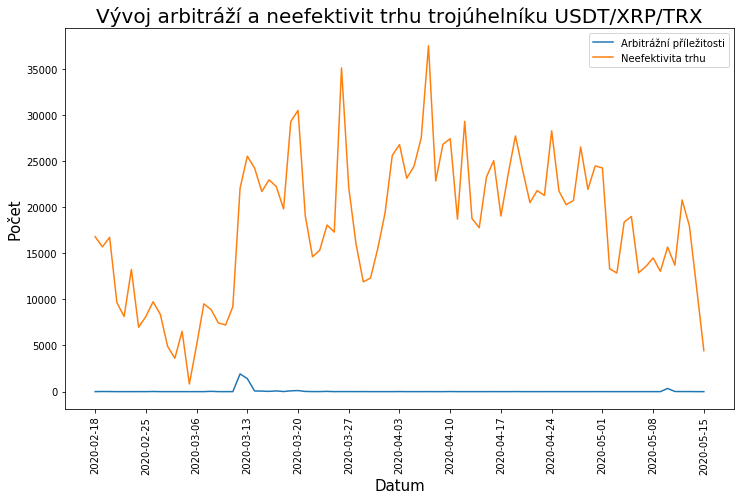

In [48]:
for triangle in best_triangles:
    values = triangle.get_arbitrages_counts()
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 7)
    ax.plot(*zip(*sorted(dict(zip(values[3], values[0])).items())), label='Arbitrážní příležitosti')
    ax.plot(*zip(*sorted(dict(zip(values[3], values[1])).items())), label='Neefektivita trhu')
    ax.set_xticks(range(0, len(values[3]), 7))
    ax.legend()
    plt.xticks(rotation=90)
    plt.ylabel("Počet", fontsize=15)
    plt.xlabel("Datum", fontsize=15)
    plt.title('Vývoj arbitráží a neefektivit trhu trojúhelníku ' + triangle.formatted_name, fontsize=title_font_size)
    plt.savefig(os.path.join('images/occurences' + triangle.name + '.png'), dpi=300, format='png')
    plt.show()

**Vykreslení a uložení grafů porovnávajících počet arbitráží s počtem neefektivit trhu a s počtem celkových transakcí.**

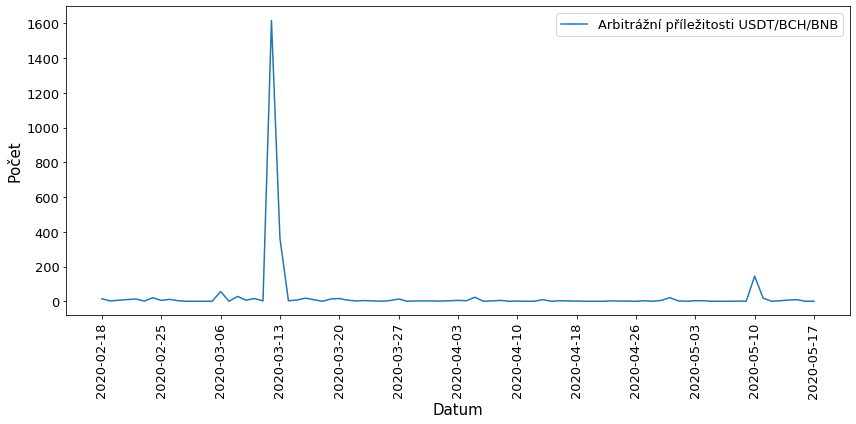

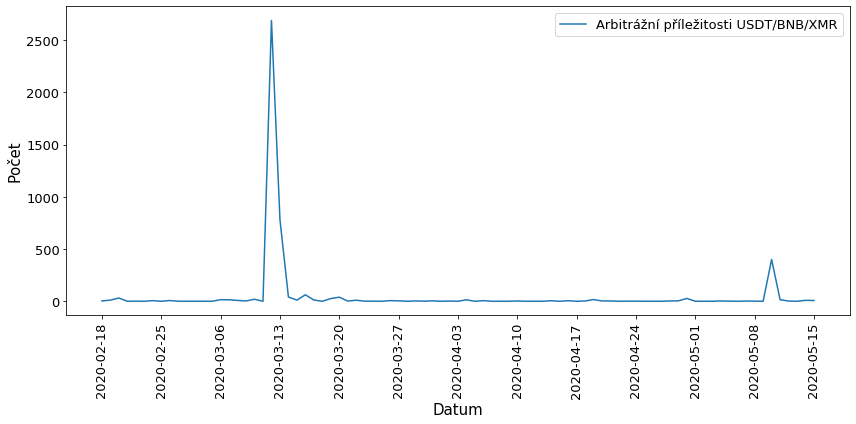

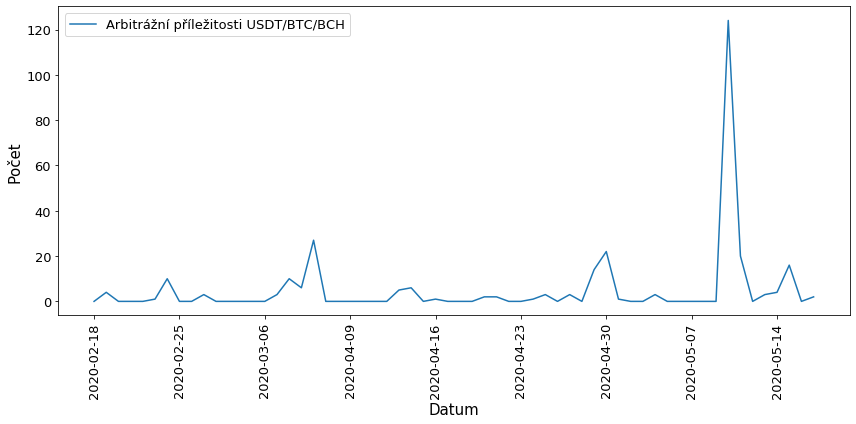

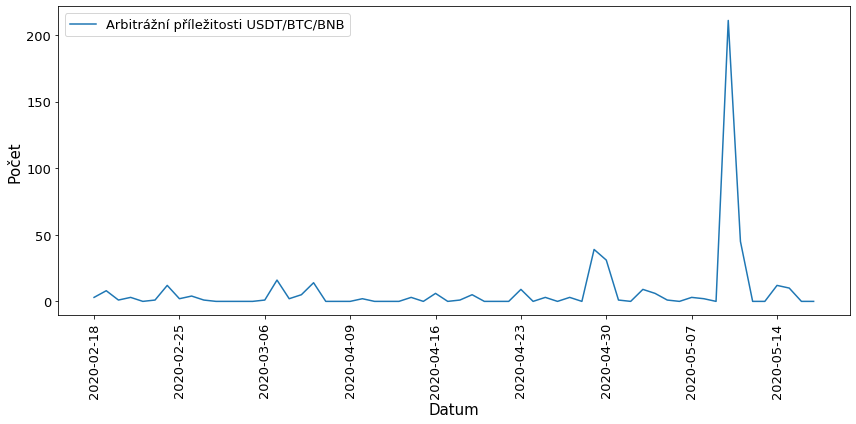

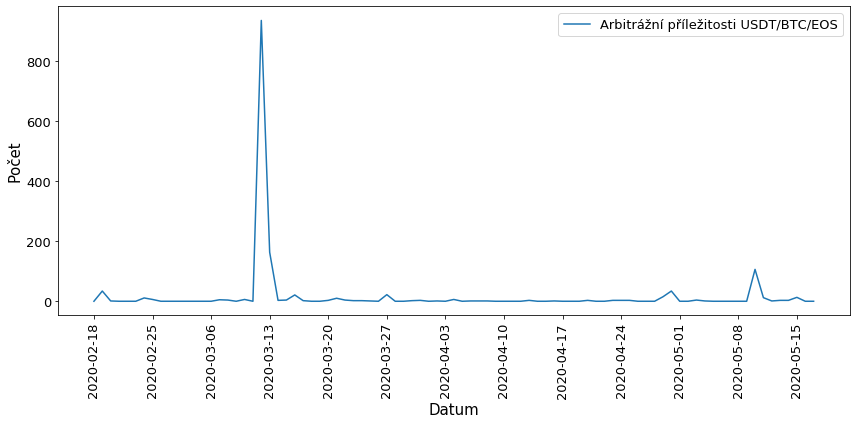

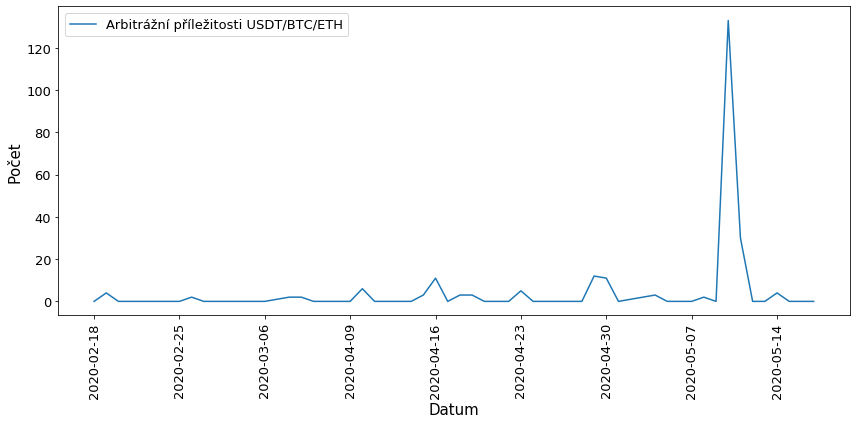

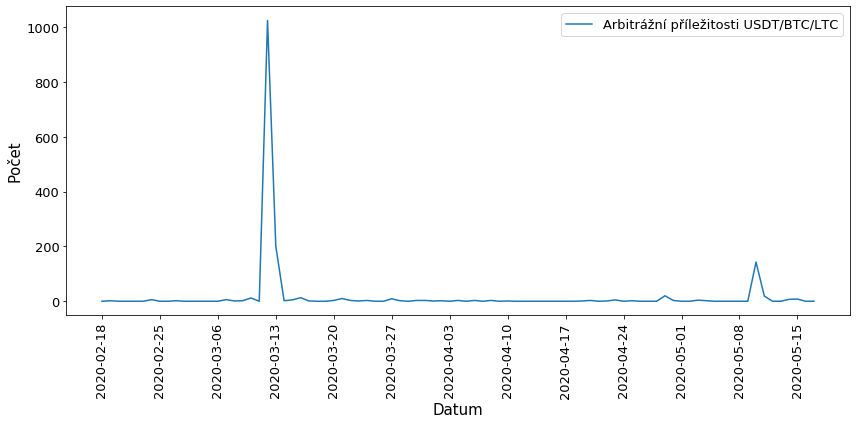

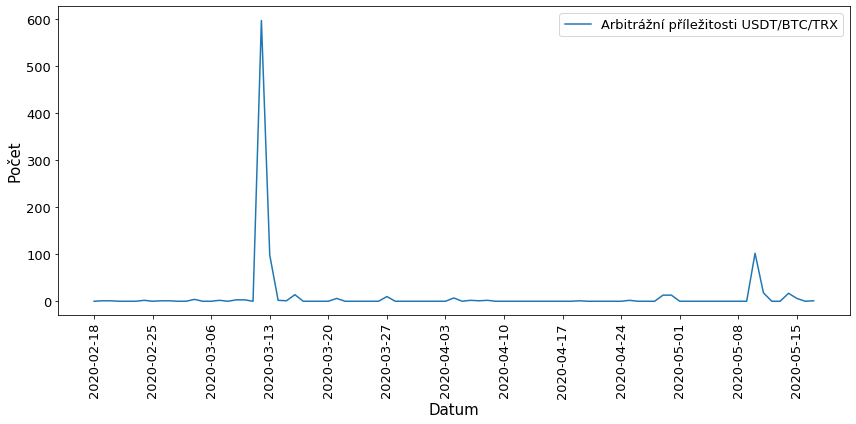

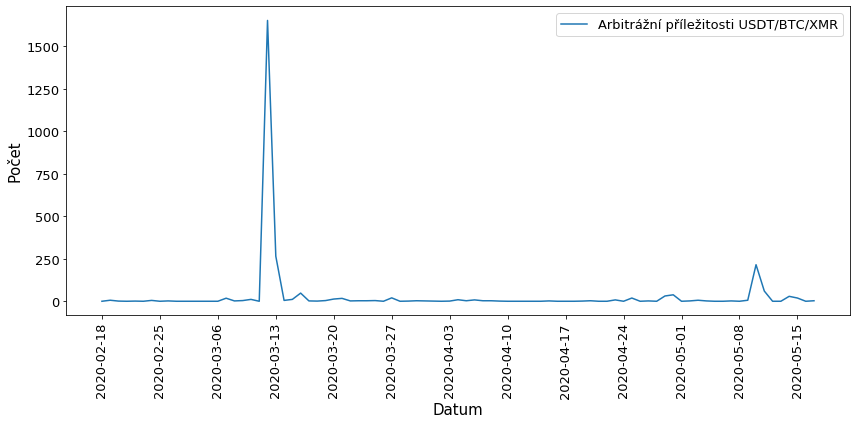

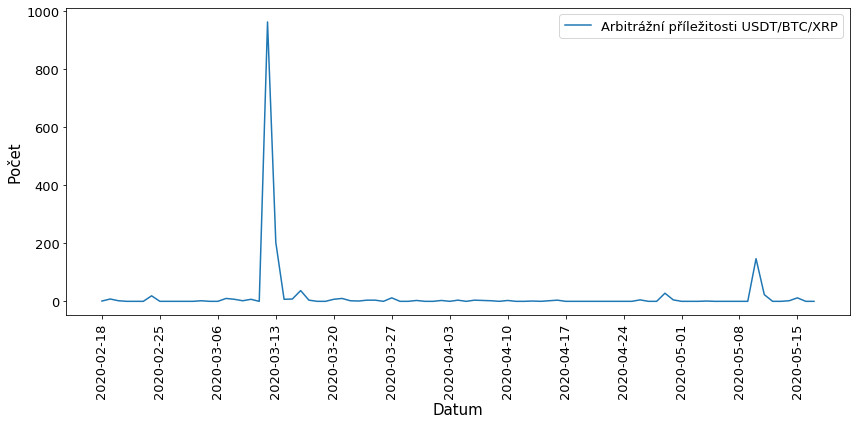

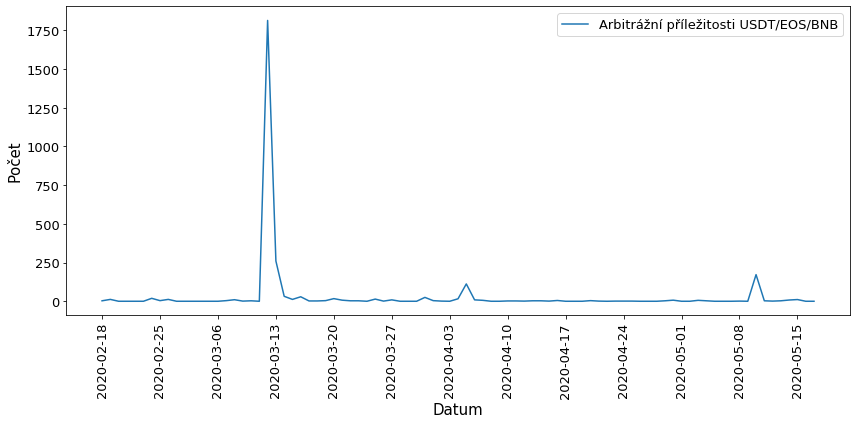

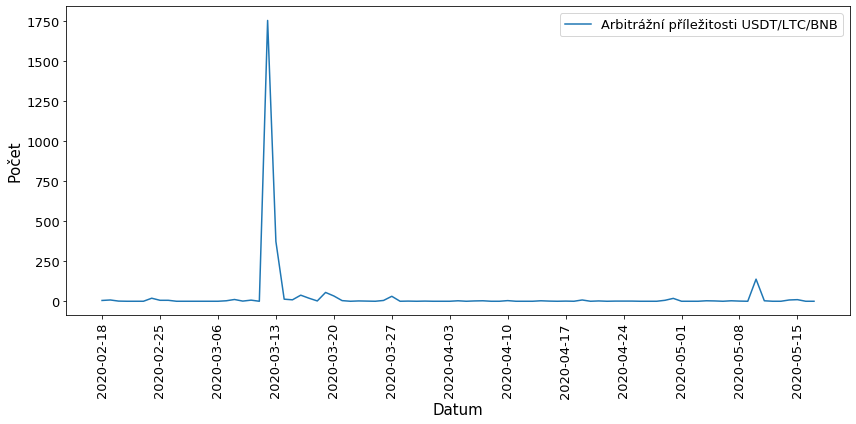

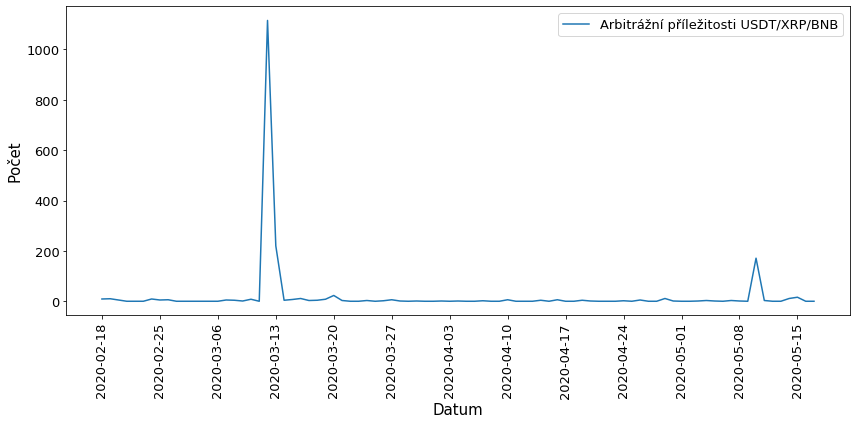

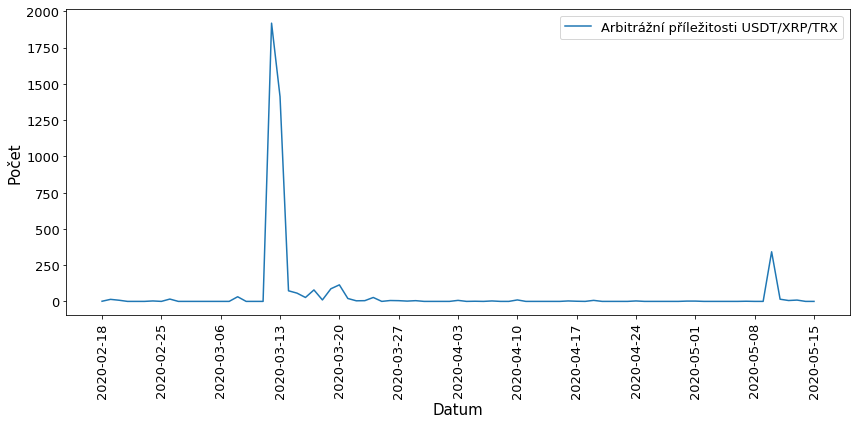

In [49]:
for triangle in best_triangles:
    values = triangle.get_arbitrages_counts()
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 6)
    ax.plot(*zip(*sorted(dict(zip(values[3], values[0])).items())), label='Arbitrážní příležitosti ' + triangle.formatted_name)
    ax.set_xticks(range(0, len(values[3]), 7))
    ax.legend(fontsize=13)
    plt.xticks(rotation=90, fontsize=13)
    plt.yticks(fontsize=13)
    plt.ylabel("Počet", fontsize=15)
    plt.xlabel("Datum", fontsize=15)
    plt.tight_layout()
#     plt.title('Vývoj arbitrážních příležitostí na trojúhelníku ' + triangle.formatted_name, fontsize=title_font_size)
    plt.savefig(os.path.join('images/occurences_arbitrage_' + triangle.name + '.png'), dpi=300, format='png')
    plt.show()

**Vykreslení grafu porovnávajícího výskyty arbitráží nejlepších trojúhelníků.**

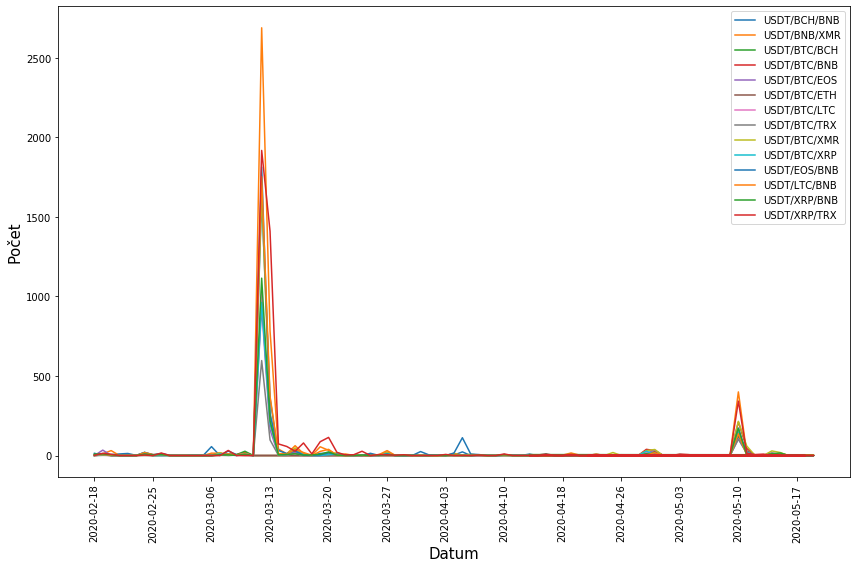

In [50]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
for triangle in best_triangles:
    values = triangle.get_arbitrages_counts()
    ax.plot(*zip(*sorted(dict(zip(values[3], values[0])).items())), label=triangle.formatted_name)
ax.set_xticks(range(0, len(values[3]), 7))
ax.legend()
plt.xticks(rotation=90)
plt.ylabel("Počet", fontsize=15)
plt.xlabel("Datum", fontsize=15)
# plt.title('Vývoj arbitrážních příležitostí nejlepších trojúhelníků', fontsize=title_font_size)
plt.tight_layout()
plt.savefig(os.path.join('images/occurence_of_best.png'), dpi=300, format='png')
plt.show()